# Машинное обучение, ФКН ВШЭ

## Практическое задание 3. Градиентный спуск своими руками

### Общая информация
Дата выдачи: **12.10.2022**

Мягкий дедлайн: **6.11.22 23:59** (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: **13.11.22 23:59**

### О задании

В данном задании необходимо реализовать обучение линейной регрессии с помощью различных вариантов градиентного спуска.


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов + 2 балла бонус.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо считываемые диаграммы.

Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.


### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-03-gd-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка**: ...

Напомним, что на лекциях и семинарах мы разбирали некоторые подходы к оптимизации функционалов по параметрам. В частности, был рассмотрен градиентный спуск и различные подходы к его реализации — полный градиентный спуск, стохастический градиентный спуск, метод импульса и другие. В качестве модели у нас будет выступать линейная регрессия.

В этом домашнем задании вам предстоит реализовать 4 различных вариации градиентного спуска, написать свою реализацию линейной регресии, сравнить методы градиентного спуска между собой на реальных данных и ещё много чего веселого и интересного!

In [168]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt

## Задание 1. Реализация градиентного спуска (3.5 балла)

В этом задании вам предстоит написать собственные реализации различных подходов к градиентному спуску с опорой на подготовленные шаблоны в файле `descents.py`.

**Все реализуемые методы должны быть векторизованы!**

### Лирическое-теоретическое отступление № 1

Основное свойство антиградиента &ndash; он указывает в сторону наискорейшего убывания функции в данной точке. Соответственно, будет логично стартовать из некоторой точки, сдвинуться в сторону антиградиента,
пересчитать антиградиент и снова сдвинуться в его сторону и т.д. Запишем это более формально.

Пусть $w_0$ &ndash; начальный набор параметров (например, нулевой или сгенерированный из некоторого
случайного распределения). Тогда ванильный градиентный спуск состоит в повторении следующих шагов до сходимости:

$$
    w_{k + 1} = w_{k} - \eta_{k} \nabla_{w} Q(w_{k}).
$$

### Лирическое-теоретическое отступление № 2

На семинаре про [матрично-векторное дифференцирование](https://github.com/esokolov/ml-course-hse/blob/master/2022-fall/seminars/sem03-vector-diff.pdf) вы должны были обсуждать дифференцирование функции потерь MSE в матричном виде.

### Задание 1.0. Градиент MSE в матричном виде (0 баллов).

Напомним, что функция потерь MSE записывается в матричном виде как:

$$
    Q(w) = \dfrac{1}{\ell} \left( y - Xw \right)^T \left( y - Xw \right)
$$

Выпишите ниже (подсмотрев в семинар или решив самостоятельно) градиент для функции потерь MSE в матричном виде.

<span style="color:green">
    $$\nabla Q(w) = 2X^T(Xw - y)$$
</span>

### Задание 1.1. Родительский класс BaseDescent (0.5 балла).

Реализуйте функции `calc_loss` (вычисление MSE для переданных $x$ и $y$) и `predict` (предсказание $y_{pred}$ для переданных $x$) в классе `BaseDescent`.

Все вычисления должны быть векторизованы.

In [169]:
# задаем Х и Y
num_objects = 100
dimension = 5
np.random.seed(100)

X = np.random.rand(num_objects, dimension)
Y = np.random.rand(num_objects)

In [170]:
print(X.shape, Y.shape)

(100, 5) (100,)


In [171]:
from dataclasses import dataclass
from enum import auto
from enum import Enum
from typing import Dict
from typing import Type

import numpy as np


@dataclass
class LearningRate:
    lambda_: float = 1e-3
    s0: float = 1
    p: float = 0.5

    iteration: int = 0

    def __call__(self):
        """
        Calculate learning rate according to lambda (s0/(s0 + t))^p formula
        """
        self.iteration += 1
        return self.lambda_ * (self.s0 / (self.s0 + self.iteration)) ** self.p


class LossFunction(Enum):
    MSE = auto()
    MAE = auto()
    LogCosh = auto()
    Huber = auto()


class BaseDescent:
    """
    A base class and templates for all functions
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, loss_function: LossFunction = LossFunction.MSE):
        """
        :param dimension: feature space dimension
        :param lambda_: learning rate parameter
        :param loss_function: optimized loss function
        """
        self.w: np.ndarray = np.random.rand(dimension)
        self.lr: LearningRate = LearningRate(lambda_=lambda_)
        self.loss_function: LossFunction = loss_function

    def step(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        return self.update_weights(self.calc_gradient(x, y))

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        Template for update_weights function
        Update weights with respect to gradient
        :param gradient: gradient
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        pass

    def calc_gradient(x: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Template for calc_gradient function
        Calculate gradient of loss function with respect to weights
        :param x: features array
        :param y: targets array
        :return: gradient: np.ndarray
        """
        pass

    def calc_loss(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculate loss for x and y with our weights
        :param x: features array
        :param y: targets array
        :return: loss: float
        """
        return ((((y - x @ self.w).T)@(y - x @ self.w)) / y.shape[0])
        raise NotImplementedError('BaseDescent calc_loss function not implemented')

    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Calculate predictions for x
        :param x: features array
        :return: prediction: np.ndarray
        """
        return (x @ self.w)
        raise NotImplementedError('BaseDescent predict function not implemented')


In [172]:
a = BaseDescent(dimension = 5)

print(a.calc_loss(X, Y))
print('**************')
print(a.predict(X))

0.971468876564562
**************
[1.0325662  1.4460083  0.78729546 1.26139076 1.41546158 0.72929082
 0.65219173 1.4004692  1.14989306 1.3492875  1.42399052 0.78408514
 1.60652883 1.17723312 1.40896496 1.09155046 1.4176376  1.60711548
 0.84338172 1.4883038  1.68952504 1.93695275 1.46406215 1.20745323
 1.13967147 1.14623597 1.03513937 2.29889889 1.4299111  1.21474864
 1.37129565 1.04511059 1.53687388 1.49765315 1.26429566 1.41631605
 1.15447752 1.5917219  1.84232627 1.63042767 1.67667537 1.39523976
 1.39071684 1.38647976 1.12786307 1.88995083 1.63229336 0.25163034
 1.12770301 1.77780189 2.16883762 1.29397298 1.3908684  1.49540897
 1.71753847 1.17990768 1.45053689 1.60138312 1.3207442  1.02477363
 1.02426267 0.73457927 1.43289383 0.95572852 1.14699676 1.27703112
 1.30943681 1.90671534 1.31009817 2.07453925 0.45648047 1.21373698
 1.98651416 1.19646442 1.57748949 0.64564947 0.99043293 1.41213008
 1.10118126 0.70375004 1.40800565 1.85989663 1.76512899 1.26759792
 1.74212714 0.96499506 0.9911

### Задание 1.2. Полный градиентный спуск VanillaGradientDescent (0.5 балла).

Реализуйте полный градиентный спуск заполнив пропуски в классе `VanillaGradientDescent` в файле `descents.py`. Для вычисления градиента используйте формулу выше. Шаг оптимизации:

$$
    w_{k + 1} = w_{k} - \eta_{k} \nabla_{w} Q(w_{k}).
$$

Здесь и далее функция `update_weights` должна возвращать разницу между $w_{k + 1}$ и $w_{k}$: $\quad w_{k + 1} - w_{k} = -\eta_{k} \nabla_{w} Q(w_{k})$.

Во всех методах градиентного спуска мы будем использовать следующую формулу для длины шага:

$$
    \eta_{k} = \lambda \left(\dfrac{s_0}{s_0 + k}\right)^p
$$

На практике достаточно настроить параметр $\lambda$, а остальным выставить параметры по умолчанию: $s_0 = 1, \, p = 0.5.$

<span style="color:green">
    $$\nabla Q(w) = 2X^T(Xw - y)$$
</span>

In [173]:
class VanillaGradientDescent(BaseDescent):
    """
    Full gradient descent class
    """

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        upd_w = self.lr() * gradient
        self.w -= upd_w
        return -upd_w
        raise NotImplementedError('VanillaGradientDescent update_weights function not implemented')

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        GD = 2 * (x.T@(x@self.w - y)) / y.shape[0]
        return GD
        raise NotImplementedError('VanillaGradientDescent calc_gradient function not implemented')

In [174]:
a = VanillaGradientDescent(dimension = 5)
print(a.calc_gradient(X,Y))
print('********************')
print(a.update_weights(a.calc_gradient(X,Y)))

[1.13934395 1.25334354 1.18904138 1.10193067 1.05588157]
********************
[-0.00080564 -0.00088625 -0.00084078 -0.00077918 -0.00074662]


### Лирическое-теоретическое отступление № 3

Как правило, в задачах машинного обучения функционал $Q(w)$ представим в виде суммы $\ell$ функций:

$$
    Q(w)
    =
    \frac{1}{\ell}
    \sum_{i = 1}^{\ell}
        q_i(w).
$$

В нашем домашнем задании отдельные функции $q_i(w)$ соответствуют ошибкам на отдельных объектах.

Проблема метода градиентного спуска состоит в том, что на каждом шаге необходимо вычислять градиент всей суммы (будем его называть полным градиентом):

$$
    \nabla_w Q(w)
    =
    \frac{1}{\ell}
    \sum_{i = 1}^{\ell}
        \nabla_w q_i(w).
$$

Это может быть очень трудоёмко при больших размерах выборки. В то же время точное вычисление градиента может быть не так уж необходимо &ndash; как правило, мы делаем не очень большие шаги в сторону антиградиента, и наличие в нём неточностей не должно сильно сказаться на общей траектории.

Оценить градиент суммы функций можно средним градиентов случайно взятого подмножества функций:

$$
    \nabla_{w} Q(w_{k}) \approx \dfrac{1}{|B|}\sum\limits_{i \in B}\nabla_{w} q_{i}(w_{k}),
$$
где $B$ - это случайно выбранное подмножество индексов.

В этом случае мы получим метод **стохастического градиентного спуска**.

### Задание 1.3. Стохастический градиентный спуск StochasticDescent (0.5 балла).

Реализуйте стохастический градиентный спуск заполнив пропуски в классе `StochasticDescent`. Для оценки градиента используйте формулу выше (среднее градиентов случайно выбранного батча объектов). Шаг оптимизации:

$$
    w_{k + 1} = w_{k} - \eta_{k} \dfrac{1}{|B|}\sum\limits_{i \in B}\nabla_{w} q_{i}(w_{k}).
$$

Размер батча будет являться гиперпараметром метода, семплируйте индексы для батча объектов с помощью `np.random.randint`.

In [175]:
class StochasticDescent(VanillaGradientDescent):
    """
    Stochastic gradient descent class
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, batch_size: int = 50,
                 loss_function: LossFunction = LossFunction.MSE):
        """
        :param batch_size: batch size (int)
        """
        super().__init__(dimension, lambda_, loss_function)
        self.batch_size = batch_size

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        batch = np.random.randint(x.shape[1], size=x.shape[0])
        SGD = 2 * (x[batch].T@(x[batch]@self.w - y[batch])) / y.shape[0]
        return SGD
        raise NotImplementedError('StochasticDescent calc_gradient function not implemented')

In [176]:
a = StochasticDescent(dimension = 5)
print(a.calc_gradient(X, Y))

[1.43582267 1.74644177 1.3137748  1.23673349 0.59564301]


### Лирическое-теоретическое отступление № 4

Может оказаться, что направление антиградиента сильно меняется от шага к шагу. Например, если линии уровня функционала сильно вытянуты, то из-за ортогональности градиента линиям уровня он будет менять направление на почти противоположное на каждом шаге. Такие осцилляции будут вносить сильный шум в движение, и процесс оптимизации займёт много итераций. Чтобы избежать этого, можно усреднять векторы антиградиента с нескольких предыдущих шагов &ndash; в этом случае шум уменьшится, и такой средний вектор будет указывать в сторону общего направления движения. Введём для этого вектор инерции:

\begin{align}
    &h_0 = 0, \\
    &h_{k + 1} = \alpha h_{k} + \eta_k \nabla_w Q(w_{k})
\end{align}

Здесь $\alpha$ &ndash; параметр метода, определяющей скорость затухания градиентов с предыдущих шагов. Разумеется, вместо вектора градиента может быть использована его аппроксимация. Чтобы сделать шаг градиентного спуска, просто сдвинем предыдущую точку на вектор инерции:

$$
    w_{k + 1} = w_{k} - h_{k + 1}.
$$

Заметим, что если по какой-то координате градиент постоянно меняет знак, то в результате усреднения градиентов в векторе инерции эта координата окажется близкой к нулю. Если же по координате знак градиента всегда одинаковый, то величина соответствующей координаты в векторе инерции будет большой, и мы будем делать большие шаги в соответствующем направлении.

### Задание 1.4 Метод Momentum MomentumDescent (0.5 балла).

Реализуйте градиентный спуск с методом инерции заполнив пропуски в классе `MomentumDescent`. Шаг оптимизации:

\begin{align}
    &h_0 = 0, \\
    &h_{k + 1} = \alpha h_{k} + \eta_k \nabla_w Q(w_{k}) \\
    &w_{k + 1} = w_{k} - h_{k + 1}.
\end{align}

$\alpha$ будет являться гиперпараметром метода, но в данном домашнем задании мы зафиксируем её за вас $\alpha = 0.9$.

In [177]:
class MomentumDescent(VanillaGradientDescent):
    """
    Momentum gradient descent class
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, loss_function: LossFunction = LossFunction.MSE):
        super().__init__(dimension, lambda_, loss_function)
        self.alpha: float = 0.9

        self.h: np.ndarray = np.zeros(dimension)

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        self.h = self.alpha*self.h + self.lr()*gradient
        self.w -= self.h
        return -self.h
        raise NotImplementedError('MomentumDescent update_weights function not implemented')

In [178]:
a = MomentumDescent(dimension = 5)
print(a.update_weights(a.calc_gradient(X, Y)))

[-0.00081899 -0.00084427 -0.00081258 -0.00078922 -0.00083007]


### Лирическое-теоретическое отступление № 5

Градиентный спуск очень чувствителен к выбору длины шага. Если шаг большой, то есть риск, что мы будем перескакивать через точку минимума; если же шаг маленький, то для нахождения минимума потребуется много итераций. При этом нет способов заранее определить правильный размер шага &ndash; к тому же, схемы с постепенным уменьшением шага по мере итераций могут тоже плохо работать.

В методе AdaGrad предлагается сделать свою длину шага для каждой компоненты вектора параметров. При этом шаг будет тем меньше, чем более длинные шаги мы делали на предыдущих итерациях:

\begin{align}
    &G_{kj} = G_{k-1,j} + (\nabla_w Q(w_{k - 1}))_j^2; \\
    &w_{jk} = w_{j,k-1} - \frac{\eta_t}{\sqrt{G_{kj}} + \varepsilon} (\nabla_w Q(w_{k - 1}))_j.
\end{align}

Здесь $\varepsilon$ небольшая константа, которая предотвращает деление на ноль.

В данном методе можно зафксировать длину шага (например, $\eta_k = 0.01$) и не подбирать её в процессе обучения. Отметим, что данный метод подходит для разреженных задач, в которых у каждого объекта большинство признаков равны нулю. Для признаков, у которых ненулевые значения встречаются редко, будут делаться большие шаги; если же какой-то признак часто является ненулевым, то шаги по нему будут небольшими.

У метода AdaGrad есть большой недостаток: переменная $G_{kj}$ монотонно растёт, из-за чего шаги становятся всё медленнее и могут остановиться ещё до того, как достигнут минимум функционала. Проблема решается в методе RMSprop, где используется экспоненциальное затухание градиентов:

$$
    G_{kj} = \alpha G_{k-1,j} + (1 - \alpha) (\nabla_w Q(w^{(k-1)}))_j^2.
$$

В этом случае размер шага по координате зависит в основном от того, насколько
быстро мы двигались по ней на последних итерациях.

Можно объединить идеи описанных выше методов: накапливать градиенты со всех прошлых шагов для
избежания осцилляций и делать адаптивную длину шага по каждому параметру.

### Задание 1.5. Метод Adam (Adaptive Moment Estimation) (1.5 балла).

![](adam_meme.png)

Реализуйте градиентный спуск с методом Adam заполнив пропуски в классе `Adam`. Шаг оптимизации:

\begin{align}
    &m_0 = 0, \quad v_0 = 0; \\ \\
    &m_{k + 1} = \beta_1 m_k + (1 - \beta_1) \nabla_w Q(w_{k}); \\ \\
    &v_{k + 1} = \beta_2 v_k + (1 - \beta_2) \left(\nabla_w Q(w_{k})\right)^2; \\ \\
    &\widehat{m}_{k} = \dfrac{m_k}{1 - \beta_1^{k}}, \quad \widehat{v}_{k} = \dfrac{v_k}{1 - \beta_2^{k}}; \\ \\
    &w_{k + 1} = w_{k} - \dfrac{\eta_k}{\sqrt{\widehat{v}_{k + 1}} + \varepsilon} \widehat{m}_{k + 1}.
\end{align}

$\beta_1 = 0.9, \beta_2 = 0.999$ и $\varepsilon = 10^{-8}$ будут зафиксированы за вас.

In [179]:
class Adam(VanillaGradientDescent):
    """
    Adaptive Moment Estimation gradient descent class
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, loss_function: LossFunction = LossFunction.MSE):
        super().__init__(dimension, lambda_, loss_function)
        self.eps: float = 1e-8

        self.m: np.ndarray = np.zeros(dimension)
        self.v: np.ndarray = np.zeros(dimension)

        self.beta_1: float = 0.9
        self.beta_2: float = 0.999

        self.iteration: int = 0

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        self.iteration += 1
        self.m = self.beta_1 * self.m + (1 - self.beta_1)*gradient
        self.v = self.beta_2 * self.v + (1 - self.beta_2)*(gradient**2)
        m_hat = self.m / (1 - self.beta_1**self.iteration)
        v_hat = self.v / (1 - self.beta_2**self.iteration)
        w_st = -self.lr() / (np.sqrt(v_hat) + self.eps) * m_hat
        self.w += w_st
        return w_st
        raise NotImplementedError('Adagrad update_weights function not implemented')

In [180]:
a = Adam(dimension = 5)
print(a.update_weights(a.calc_gradient(X, Y)))

[-0.00070711 -0.00070711 -0.00070711 -0.00070711 -0.00070711]


## Задание 2. Реализация линейной регресии (0.5 балла)

В этом задании вам предстоит написать свою реализацию линейной регресии, обучаемой с использованием градиентного спуска, с опорой на подготовленные шаблоны в файле `linear_regression.py` - **LinearRegression**. По сути линейная регрессия будет оберткой, которая запускает обучение 

Необходимо соблюдать следующие условия:

* Все вычисления должны быть векторизованы;
* Циклы средствами python допускаются только для итераций градиентного спуска;
* В качестве критерия остановки необходимо использовать (одновременно):
    * Квадрат евклидовой нормы разности весов на двух соседних итерациях меньше `tolerance`;
    * Разность весов содержит наны;
    * Достижение максимального числа итераций `max_iter`.
* Будем считать, что все данные, которые поступают на вход имеют столбец единичек последним столбцом;
* Чтобы проследить за сходимостью оптимизационного процесса будем использовать `loss_history`, в нём будем хранить значения функции потерь до каждого шага, начиная с нулевого (до первого шага по антиградиенту) и значение функции потерь после оптимизации.

In [181]:
from __future__ import annotations

from typing import List

import numpy as np

from descents import BaseDescent
from descents import get_descent


class LinearRegression:
    """
    Linear regression class
    """

    def __init__(self, descent_config: dict, tolerance: float = 1e-4, max_iter: int = 300):
        """
        :param descent_config: gradient descent config
        :param tolerance: stopping criterion for square of euclidean norm of weight difference (float)
        :param max_iter: stopping criterion for iterations (int)
        """
        self.descent: BaseDescent = get_descent(descent_config)

        self.tolerance: float = tolerance
        self.max_iter: int = max_iter

        self.loss_history: List[float] = []

    def fit(self, x: np.ndarray, y: np.ndarray) -> LinearRegression:
        """
        Fitting descent weights for x and y dataset
        :param x: features array
        :param y: targets array
        :return: self
        """
        for _ in range(self.max_iter):
            self.loss_history.append(self.calc_loss(x, y))
            step = self.descent.step(x, y)
            if (np.linalg.norm(step)**2 <= self.tolerance) | (np.isnan(self.descent.w).any()):
                break
        self.loss_history.append(self.calc_loss(x, y))
        return self
        raise NotImplementedError('LinearRegression fit function not implemented')

    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Predicting targets for x dataset
        :param x: features array
        :return: prediction: np.ndarray
        """
        return self.descent.predict(x)

    def calc_loss(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculating loss for x and y dataset
        :param x: features array
        :param y: targets array
        """
        return self.descent.calc_loss(x, y)

## Задание 3. Проверка кода (0 баллов)

In [182]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [183]:
%autoreload 2

import numpy as np

from descents import get_descent
from linear_regression import LinearRegression

In [184]:
num_objects = 100
dimension = 5

x = np.random.rand(num_objects, dimension)
y = np.random.rand(num_objects)

In [185]:
# Descents

descent_config = {
    'descent_name': 'some name that we will replace in the future',
    'kwargs': {
        'dimension': dimension
    }
}

for descent_name in ['full', 'stochastic', 'momentum', 'adam']:
    descent_config['descent_name'] = descent_name
    descent = get_descent(descent_config)

    diff = descent.step(x, y)
    gradient = descent.calc_gradient(x, y)
    predictions = descent.predict(x)

    assert gradient.shape[0] == dimension, f'Gradient failed for descent {descent_name}'
    assert diff.shape[0] == dimension, f'Weights failed for descent {descent_name}'
    assert predictions.shape == y.shape, f'Prediction failed for descent {descent_name}'

In [186]:
# LinearRegression

max_iter = 10
tolerance = 0

descent_config = {
    'descent_name': 'stochastic',
    'kwargs': {
        'dimension': dimension,
        'batch_size': 10
    }
}

regression = LinearRegression(
    descent_config=descent_config,
    tolerance=tolerance,
    max_iter=max_iter
)

regression.fit(x, y)

assert len(regression.loss_history) == max_iter + 1, 'Loss history failed'

Если ваше решение прошло все тесты локально, то теперь пришло время протестировать его в [Яндекс Контесте](https://contest.yandex.ru/contest/41257/enter/).

Для каждой задачи из контеста вставьте ссылку на успешную посылку:

* **VanillaGradientDescent**: [ссылка 1](https://contest.yandex.ru/contest/41257/run-report/73828493/)


* **StochasticDescent**: [ссылка 2](https://contest.yandex.ru/contest/41257/run-report/73829606/)


* **MomentumDescent**: [ссылка 3](https://contest.yandex.ru/contest/41257/run-report/73830310/)


* **Adam**: [ссылка 4](https://contest.yandex.ru/contest/41257/run-report/73837014/)


* **LinearRegression**: [ссылка 5](https://contest.yandex.ru/contest/41257/run-report/73841010/)

## Задание 4. Работа с данными (1 балл)

Мы будем использовать датасет объявлений по продаже машин на немецком Ebay. В задаче предсказания целевой переменной для нас будет являться цена.

* Постройте график распределения целевой переменной в данных, подумайте, нужно ли заменить её на логарифм. Присутствуют ли выбросы в данных с аномальной ценой? Если да, то удалите их из данных.

* Проведите исследование данных:
    * Проанализируйте тип столбцов, постройте графики зависимости целевой переменной от признака, распределения значений признака;
    * Подумайте, какие признаки могут быть полезными на основе этих графиков, обработайте выбросы;
    * Подумайте, какие трансформации признаков из известных вам будет уместно применить;
    * Разделите полезные признаки на категориальные, вещественные и те, которые не надо предобрабатывать.
* Разделите данные на обучающую, валидационную и тестовую выборки в отношении 8:1:1.

In [187]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from descents import get_descent
from linear_regression import LinearRegression

sns.set(style='darkgrid')

In [188]:
data = pd.read_csv('autos.csv')

In [189]:
data.head()

,brand,model,vehicleType,gearbox,fuelType,notRepairedDamage,powerPS,kilometer,autoAgeMonths,price
0,volkswagen,golf,kleinwagen,manuell,benzin,nein,75,150000,177,1500
1,skoda,fabia,kleinwagen,manuell,diesel,nein,69,90000,93,3600
2,bmw,3er,limousine,manuell,benzin,ja,102,150000,246,650
3,peugeot,2_reihe,cabrio,manuell,benzin,nein,109,150000,140,2200
4,mazda,3_reihe,limousine,manuell,benzin,nein,105,150000,136,2000


Колонки в данных:

* `brand` - название бренда автомобиля
* `model` - название модели автомобиля
* `vehicleType` - тип транспортного средства
* `gearbox` - тип трансмисcии
* `fuelType` - какой вид топлива использует автомобиль
* `notRepairedDamage` - есть ли в автомобиле неисправность, которая еще не устранена
* `powerPS` - мощность автомобиля в PS (метрическая лошадиная сила)
* `kilometer` - сколько километров проехал автомобиль, пробег
* `autoAgeMonths` - возраст автомобиля в месяцах


* `price` - цена, указанная в объявлении о продаже автомобиля (целевая переменная)

In [190]:
# YOUR CODE (data split into train/val/test):
from sklearn.model_selection import train_test_split

Y = data[["price"]]
X = data.drop(columns="price")

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.8)
X_test, X_validate, Y_test, Y_validate = train_test_split(X_test, Y_test, test_size=0.5)

In [191]:
# для удобства объединим X_train и Y_train, чтобы можно было одновременно удалять выбросы
data_train = X_train.merge(Y_train, left_index=True, right_index = True)
data_train

,brand,model,vehicleType,gearbox,fuelType,notRepairedDamage,powerPS,kilometer,autoAgeMonths,price
91207,bmw,3er,coupe,automatik,benzin,nein,102,60000,224,2500
31864,opel,omega,kombi,automatik,benzin,nein,170,150000,207,350
21304,bmw,3er,coupe,automatik,diesel,nein,184,70000,62,24500
224998,audi,a4,cabrio,manuell,diesel,ja,163,150000,154,4999
209474,ford,focus,bus,manuell,diesel,nein,109,150000,130,3799
...,...,...,...,...,...,...,...,...,...,...
89904,renault,clio,kleinwagen,manuell,benzin,nein,75,60000,134,3950
13335,citroen,c4,limousine,manuell,diesel,nein,109,50000,67,8250
41121,smart,fortwo,kleinwagen,automatik,benzin,nein,54,90000,195,1350
219125,opel,vectra,kombi,manuell,benzin,nein,155,150000,136,3200


### `price`

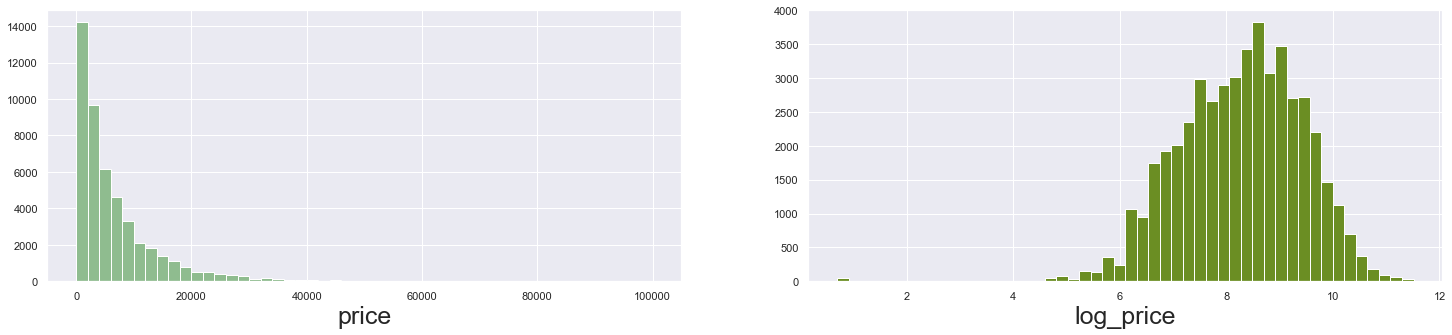

In [192]:
# Цена и ее логарим
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(25, 5))
ax[0].hist(data_train['price'], bins=50, color = 'darkseagreen')
ax[1].hist(np.log1p(data_train[['price']]), bins=50, color = 'olivedrab')

ax[0].set_xlabel("price", fontsize=25)
ax[1].set_xlabel("log_price", fontsize=25)

plt.show()

<div style="background: #f0f4e6; border: 2px solid #6b8e23;">
    <p style="margin: 15px; line-height: 1.5; text-align: left;">
        Логарифмирование было бы полезно: <br>
        $\Large\cdot$ Целевая переменная распределена не нормально<br>
        $\Large\cdot$ При предсказании абсолютного значения штраф за ошибку в предсказании значения может быть высоким

<div style="background: #f0f4e6; border: 2px solid #6b8e23;">
    <p style="margin: 15px; line-height: 1.5; text-align: left;">
        Относительно выбросов, можно заметить, что они есть, но лучше визуализируем на боксплоте<br>
        $\rightarrow$ Боксплот
        $\rightarrow$ Очистка выбросов
        $\rightarrow$ Переход к исследованию следующих элементов

In [193]:
# добавили переменную в датафрейм
data_train['log_price'] = np.log1p(data_train['price'])

# в остальных датафреймах тоже логарифмируем
Y_test['log_price'] = np.log1p(Y_test['price'])
Y_test = Y_test.drop(columns = 'price')
Y_validate['log_price'] = np.log1p(Y_validate['price'])
Y_validate = Y_validate.drop(columns = 'price')

<AxesSubplot:xlabel='log_price'>

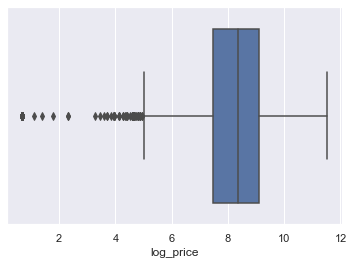

In [194]:
sns.boxplot(x = data_train['log_price'])

<AxesSubplot:xlabel='log_price', ylabel='Count'>

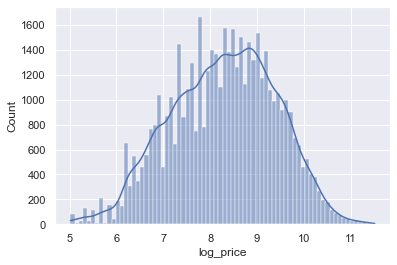

In [195]:
data_train = data_train[data_train['log_price'] > 5]
sns.histplot(data = data_train,  x = 'log_price', kde=True)

<AxesSubplot:xlabel='log_price'>

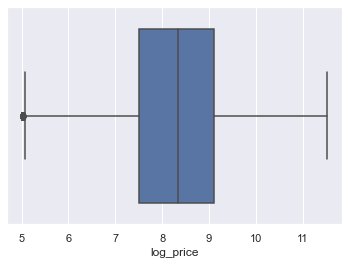

In [196]:
sns.boxplot(x = data_train['log_price'])

### `other`

In [197]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48102 entries, 91207 to 90241
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   brand              48102 non-null  object 
 1   model              48102 non-null  object 
 2   vehicleType        48102 non-null  object 
 3   gearbox            48102 non-null  object 
 4   fuelType           48102 non-null  object 
 5   notRepairedDamage  48102 non-null  object 
 6   powerPS            48102 non-null  int64  
 7   kilometer          48102 non-null  int64  
 8   autoAgeMonths      48102 non-null  int64  
 9   price              48102 non-null  int64  
 10  log_price          48102 non-null  float64
dtypes: float64(1), int64(4), object(6)
memory usage: 4.4+ MB


<div style="background: #f0f4e6; border: 2px solid #6b8e23;">
    <p style="margin: 15px; line-height: 1.5; text-align: left;">
        Помимо целевой переменной и ее логарифма есть 6 признаков с типом object и 3 численных, пропусков в данных нет

<AxesSubplot:xlabel='autoAgeMonths'>

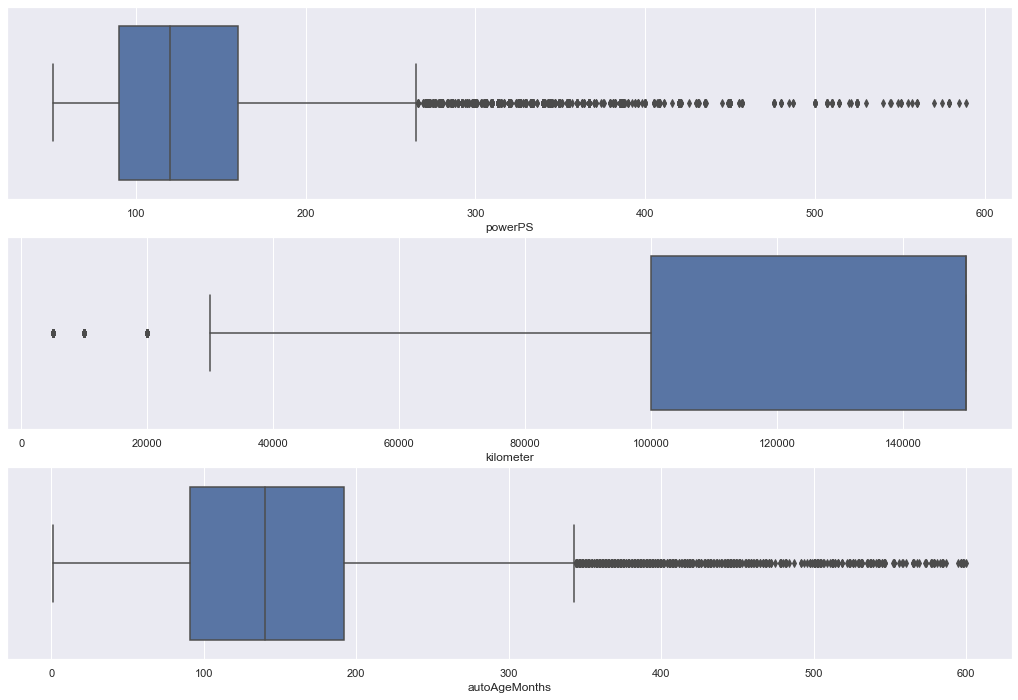

In [198]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(18, 12))

sns.boxplot(x = data_train['powerPS'], ax = ax[0])
sns.boxplot(x = data_train['kilometer'], ax = ax[1])
sns.boxplot(x = data_train['autoAgeMonths'], ax = ax[2])

<div style="background: #f0f4e6; border: 2px solid #6b8e23;">
    <p style="margin: 15px; line-height: 1.5; text-align: left;">
        Среди числовых признаков наблюдаются выбросы, которые будут удалены далее

#### `brand`

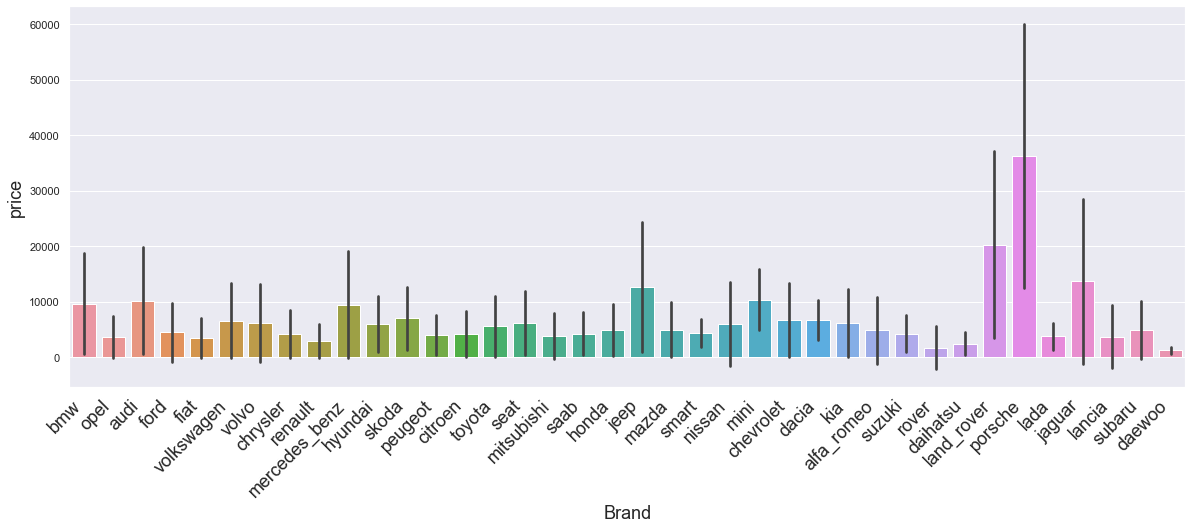

In [199]:
fig = plt.figure(figsize=(20, 7))
sns.barplot(y=data_train['price'], x=data_train['brand'], ci='sd')

plt.ylabel('price', fontsize=18)
plt.xlabel('Brand', fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=18)

plt.show()

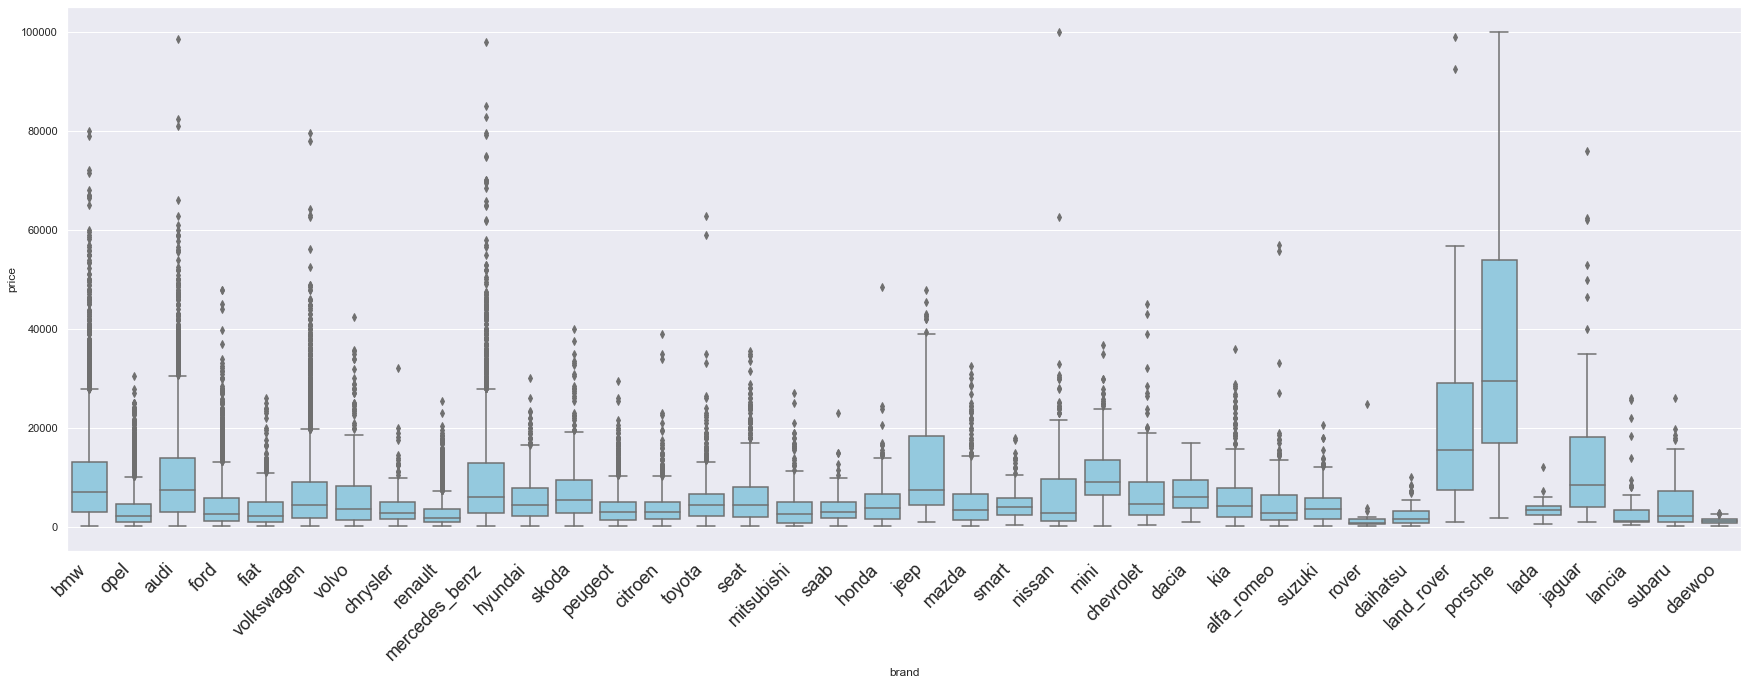

In [200]:
plt.figure(figsize =(30, 10))

sns.boxplot(x = data_train['brand'], y = data_train['price'], color='skyblue')
plt.xticks(rotation=45, ha='right', fontsize=18)

plt.show()

<div style="background: #f0f4e6; border: 2px solid #6b8e23;">
    <p style="margin: 15px; line-height: 1.5; text-align: left;">
        Признак является категориальным (на нем используем one hot encoding), полезен для вычисления, так как почти у всех брендов разные средние значения. По боксплотам заменты выбросы в кадой из категорий - данные выбросы не удаляем, так как они могут зависеть от конкретной модели и других характеристик автомобиля - будут полезны

#### `model`

In [201]:
import matplotlib.pyplot as plt
import seaborn as sns

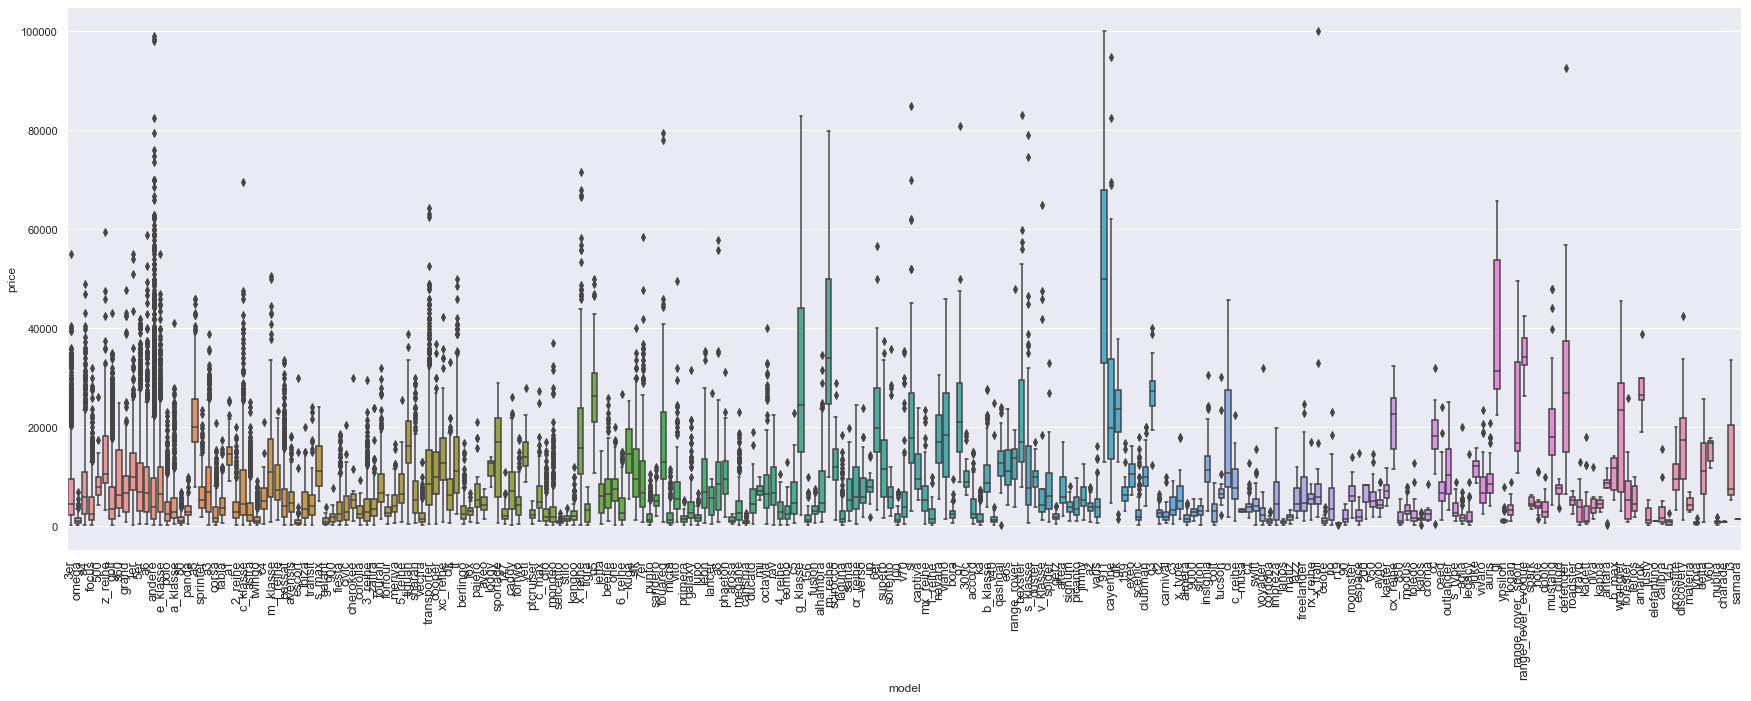

In [202]:
#почти не видно, но смысл понятен
plt.figure(figsize =(30, 10))
plt.xticks(rotation=90, fontsize = 13)
sns.boxplot(x = data_train['model'], y = data_train['price'])
plt.show()

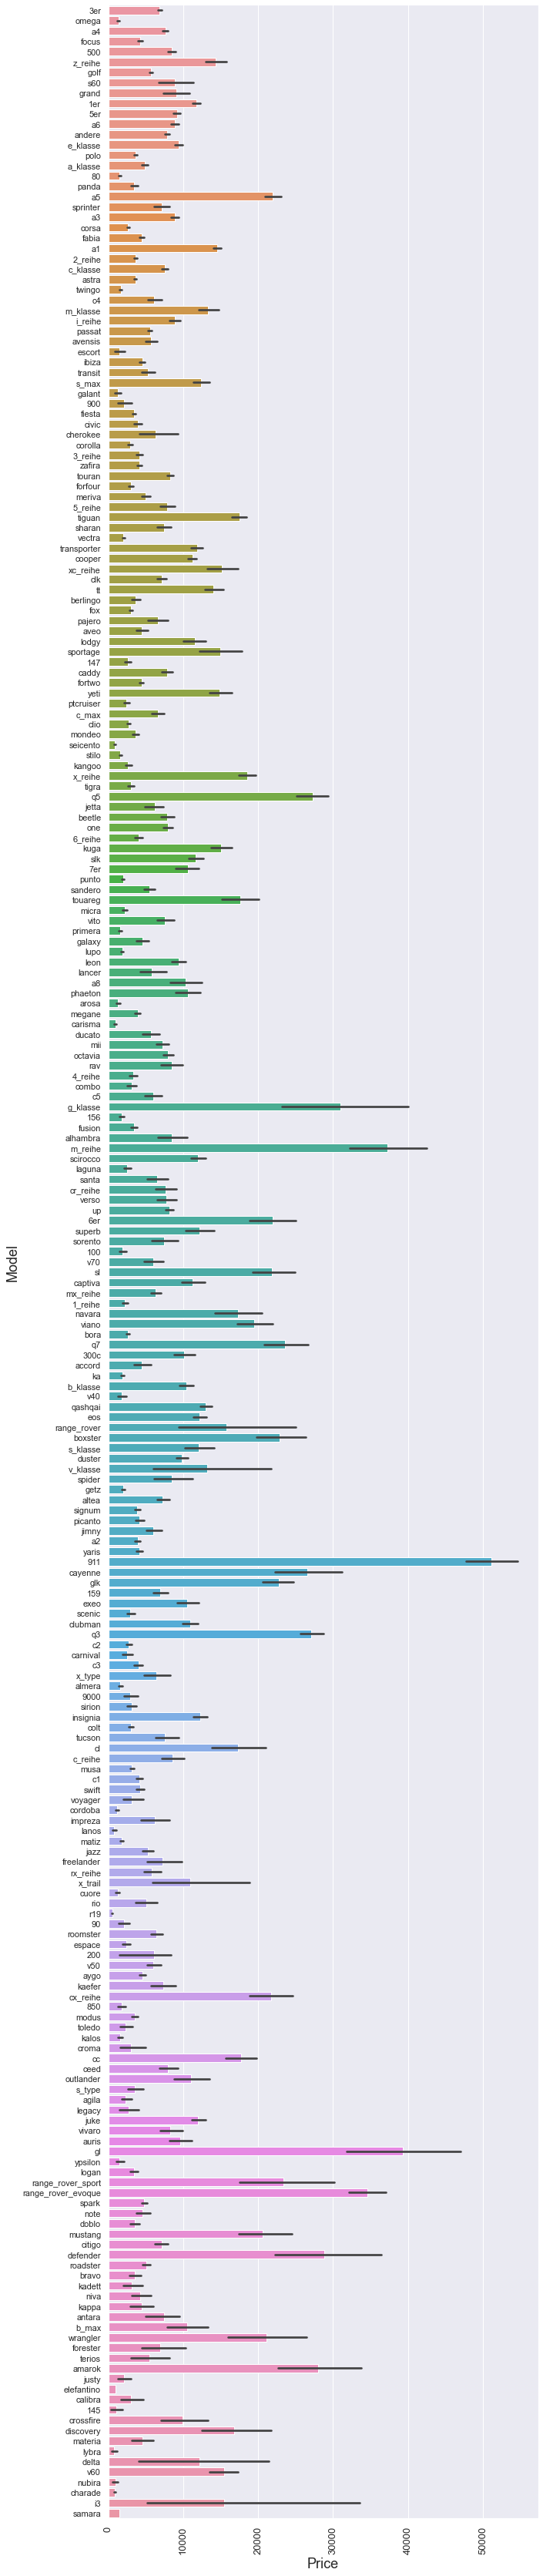

In [203]:
plt.figure(figsize =(10, 60))
sns.barplot(data=data_train, y='model', x = 'price', orient = 'h')
plt.xticks(rotation=90, fontsize = 13)
plt.ylabel('Model', fontsize=18)
plt.xlabel('Price', fontsize=18)
plt.show()

<div style="background: #f0f4e6; border: 2px solid #6b8e23;">
    <p style="margin: 15px; line-height: 1.5; text-align: left;">
        Признак является категориальным <br>
        По боксплотам заменты выбросы в кадой из категорий - данные выбросы не удаляем

#### `vehicleType`

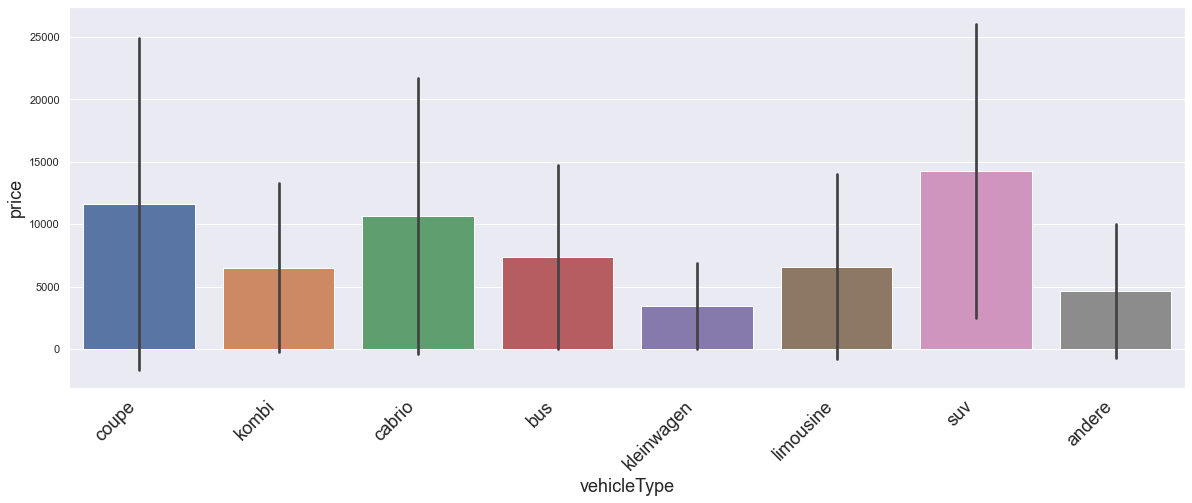

In [204]:
fig = plt.figure(figsize=(20, 7))
sns.barplot(y=data_train['price'], x=data_train['vehicleType'], ci='sd')

plt.ylabel('price', fontsize=18)
plt.xlabel('vehicleType', fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=18)

plt.show()

<div style="background: #f0f4e6; border: 2px solid #6b8e23;">
    <p style="margin: 15px; line-height: 1.5; text-align: left;">
        Признак является категориальным

#### `gearbox`

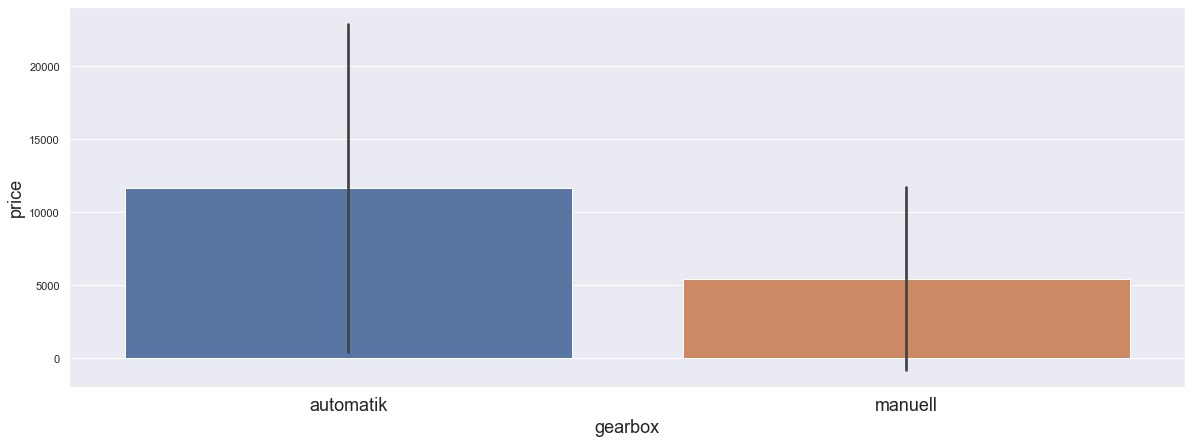

In [205]:
fig = plt.figure(figsize=(20, 7))
sns.barplot(y=data_train['price'], x=data_train['gearbox'], ci='sd')

plt.ylabel('price', fontsize=18)
plt.xlabel('gearbox', fontsize=18)
plt.xticks(fontsize=18)

plt.show()

In [230]:
data_train['gearbox'] = (
    np.where(
        data_train['gearbox'] == 'automatik',
        1, 0,
    )
)

X_test['gearbox'] = (
    np.where(
        X_test['gearbox'] == 'automatik',
        1, 0,
    )
)

X_validate['gearbox'] = (
    np.where(
        X_validate['gearbox'] == 'automatik',
        1, 0,
    )
)

<div style="background: #f0f4e6; border: 2px solid #6b8e23;">
    <p style="margin: 15px; line-height: 1.5; text-align: left;">
        Бинарный признак - OneHotEcoding на нем применен не будет

#### `fuelType`

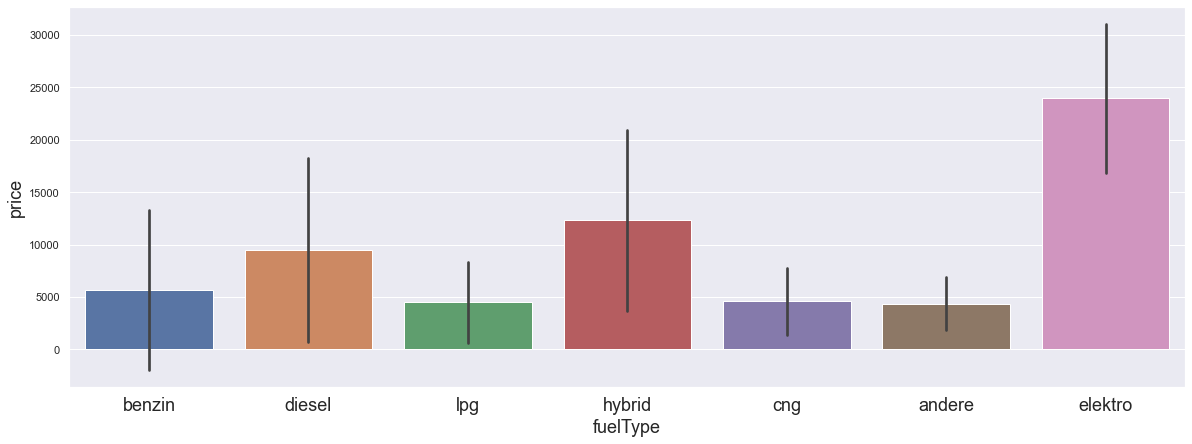

In [206]:
fig = plt.figure(figsize=(20, 7))
sns.barplot(y=data_train['price'], x=data_train['fuelType'], ci='sd')

plt.ylabel('price', fontsize=18)
plt.xlabel('fuelType', fontsize=18)
plt.xticks(fontsize=18)

plt.show()

<div style="background: #f0f4e6; border: 2px solid #6b8e23;">
    <p style="margin: 15px; line-height: 1.5; text-align: left;">
        Категориальный признак

#### `notRepairedDamage`

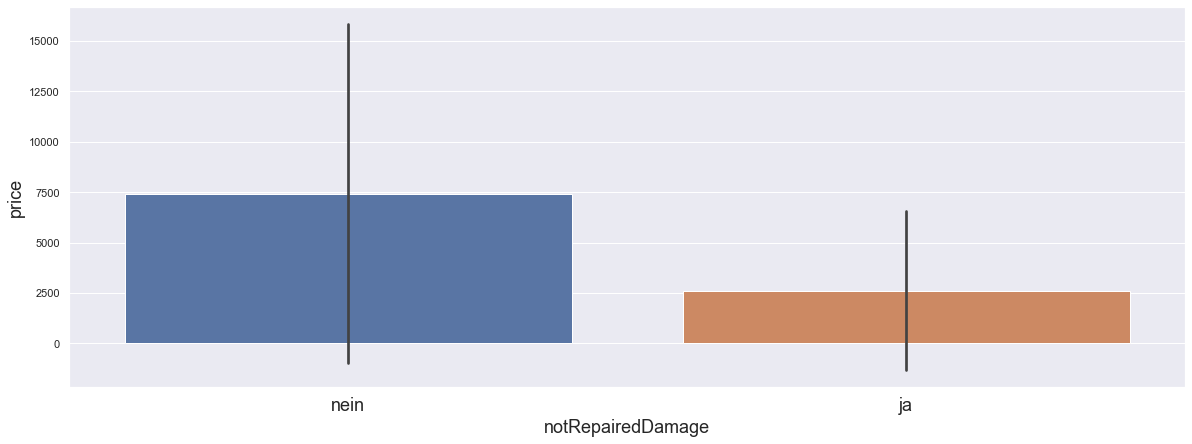

In [207]:
fig = plt.figure(figsize=(20, 7))
sns.barplot(y=data_train['price'], x=data_train['notRepairedDamage'], ci='sd')

plt.ylabel('price', fontsize=18)
plt.xlabel('notRepairedDamage', fontsize=18)
plt.xticks(fontsize=18)

plt.show()

In [229]:
data_train['notRepairedDamage'] = (
    np.where(
        data_train['notRepairedDamage'] == 'nein',
        1, 0,
    )
)

X_test['notRepairedDamage'] = (
    np.where(
        X_test['notRepairedDamage'] == 'nein',
        1, 0,
    )
)

X_validate['notRepairedDamage'] = (
    np.where(
        X_validate['notRepairedDamage'] == 'nein',
        1, 0,
    )
)

<div style="background: #f0f4e6; border: 2px solid #6b8e23;">
    <p style="margin: 15px; line-height: 1.5; text-align: left;">
        Бинарный признак - OneHotEcoding на нем применен не будет

#### `powerPS`

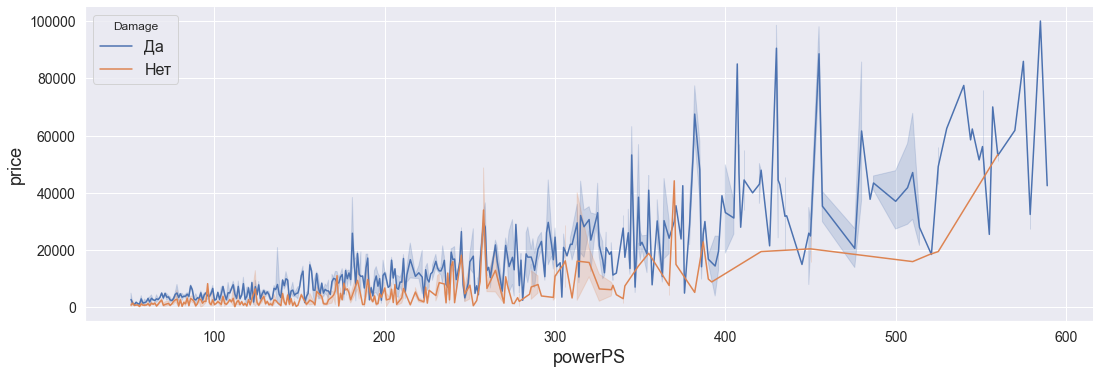

In [208]:
sns.relplot(data = data_train, x = 'powerPS', y = 'price', hue = 'notRepairedDamage', height=5, aspect=3, kind = 'line', legend = False)

plt.ylabel('price', fontsize=18)
plt.xlabel('powerPS', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['Да', 'Нет'], title='Damage', fontsize=16)

plt.show()

<div style="background: #f0f4e6; border: 2px solid #6b8e23;">
    <p style="margin: 15px; line-height: 1.5; text-align: left;">
        Числовой признак<br>
        Осциляция цены высокая. При повреждении цена автомобиля снижается, несмотря на высокую мощность - соотвутствует здравому смыслу

#### `kilometer`

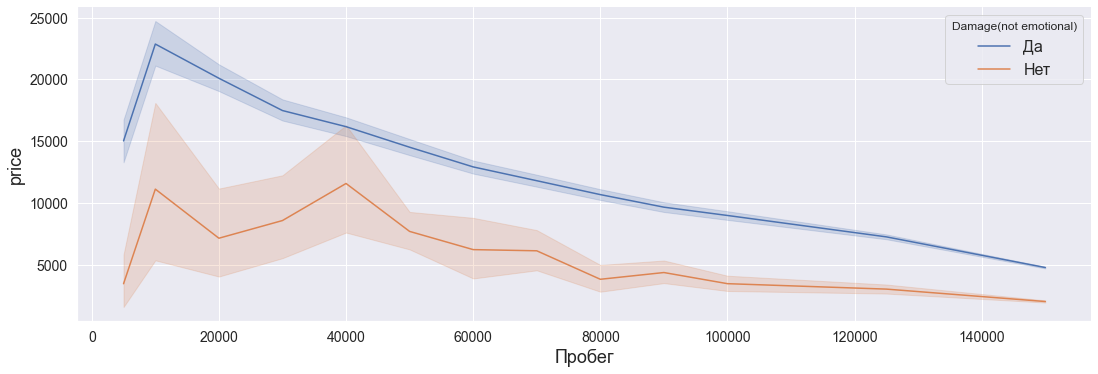

In [209]:
sns.relplot(data = data_train, x = 'kilometer', y = 'price', hue = 'notRepairedDamage', height=5, aspect=3, kind = 'line', legend = False)

plt.ylabel('price', fontsize=18)
plt.xlabel('Пробег', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['Да', 'Нет'], title='Damage(not emotional)', fontsize=16)

plt.show()

<div style="background: #f0f4e6; border: 2px solid #6b8e23;">
    <p style="margin: 15px; line-height: 1.5; text-align: left;">
        Числовой признак<br>
        Колебания цены не высокие. При увеличении пробега цена уменьшается - логично)

#### `autoAgeMonths`

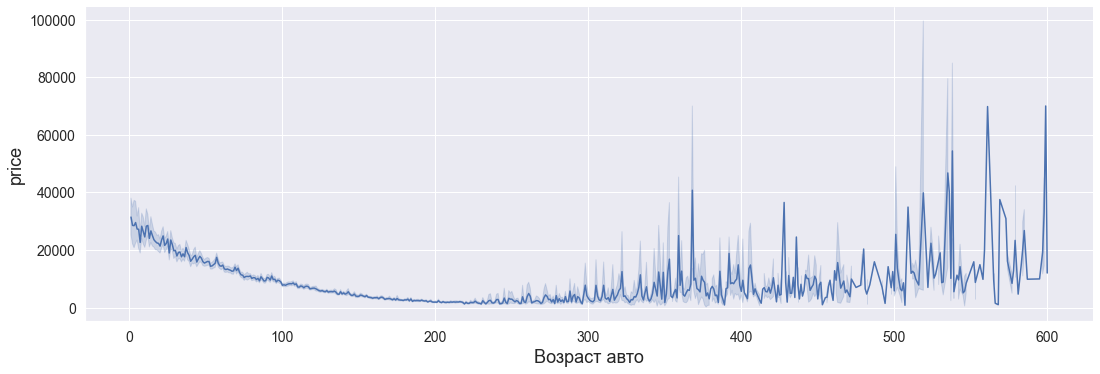

In [210]:
sns.relplot(data = data_train, x = 'autoAgeMonths', y = 'price', height=5, aspect=3, kind = 'line')

plt.ylabel('price', fontsize=18)
plt.xlabel('Возраст авто', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

<div style="background: #f0f4e6; border: 2px solid #6b8e23;">
    <p style="margin: 15px; line-height: 1.5; text-align: left;">
        Числовой признак<br>
        Необычно - сначала цена авто идет вниз с увеличением возраста (играет роль амортизация), а далее начинаются значительные колебания цены <br>
        <s>Может автомобиль как хорошее вино - с годами становится лучше.</s> <br>
        Более применима гипотеза, что некоторые модели через 25 (300 месяцев) лет больше не выпускаются и на некоторые повышается спрос из-за их исключительности, редкости и стойкости - через 25 лет авто еще на ходу. Например, Chevrolet Impala 1967 года выпуска>>><br>

<details>
  <summary>>>>Пасхалка (tap)</summary>
  <p><img src="https://i.gifer.com/TPaB.gif" style="width: 600px"></p>
  <p><img src="https://i.gifer.com/2OaI.gif" style="width: 600px"></p>
</details>

<AxesSubplot:xlabel='autoAgeMonths'>

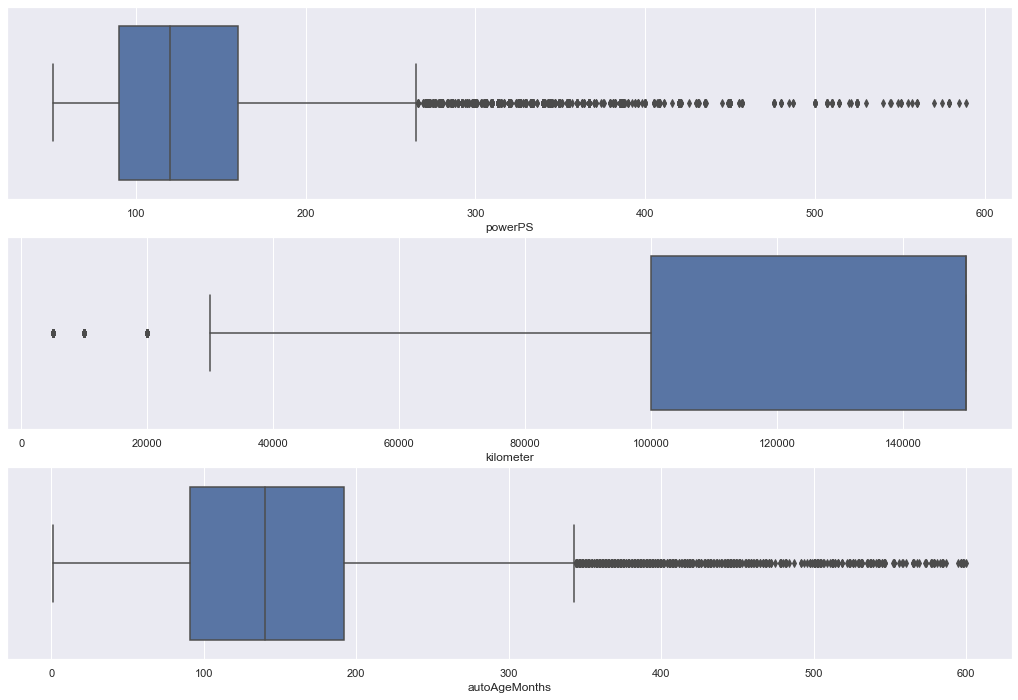

In [211]:
# видим выбросы - удаляем
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(18, 12))

sns.boxplot(x = data_train['powerPS'], ax = ax[0])
sns.boxplot(x = data_train['kilometer'], ax = ax[1])
sns.boxplot(x = data_train['autoAgeMonths'], ax = ax[2])

In [212]:
data_train = data_train[data_train['powerPS'] < 250]
data_train = data_train[data_train['kilometer'] > 25000]
data_train = data_train[data_train['autoAgeMonths'] < 330]

<AxesSubplot:xlabel='autoAgeMonths'>

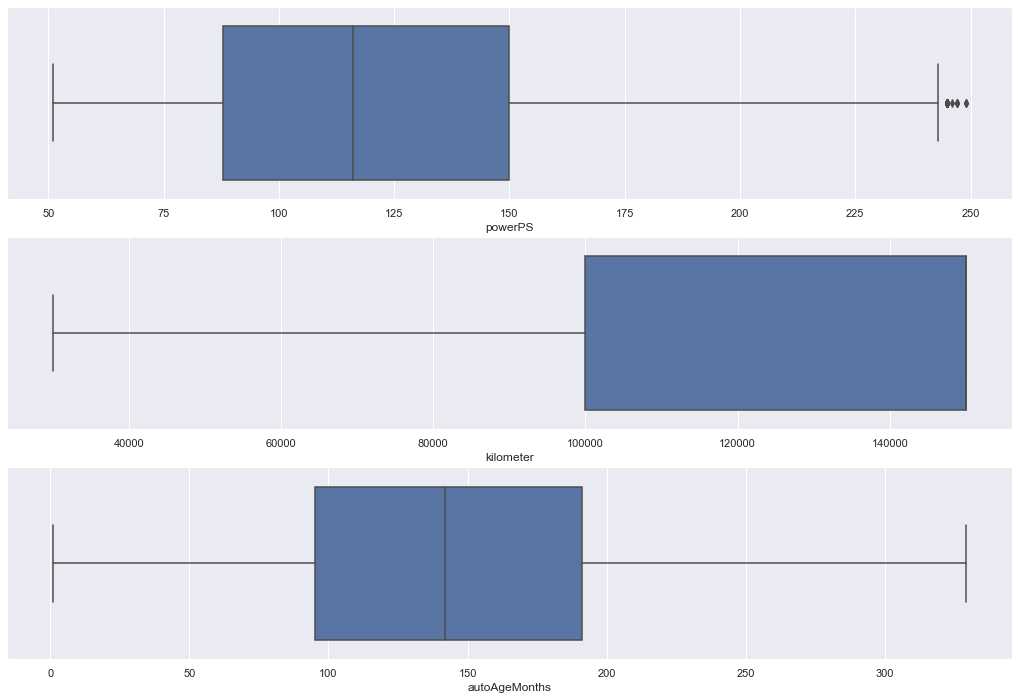

In [213]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(18, 12))

sns.boxplot(x = data_train['powerPS'], ax = ax[0])
sns.boxplot(x = data_train['kilometer'], ax = ax[1])
sns.boxplot(x = data_train['autoAgeMonths'], ax = ax[2])

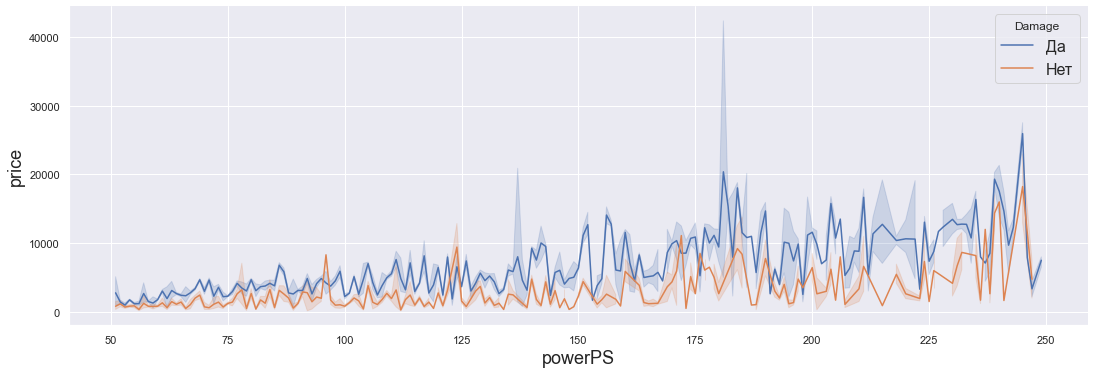

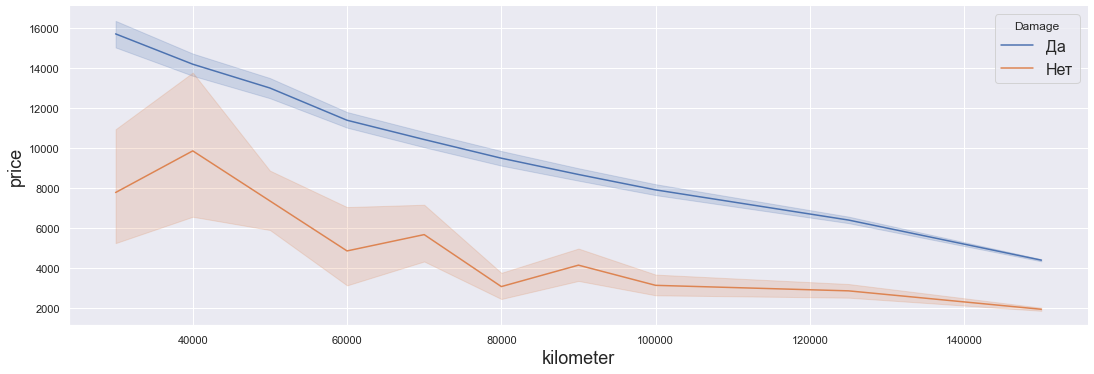

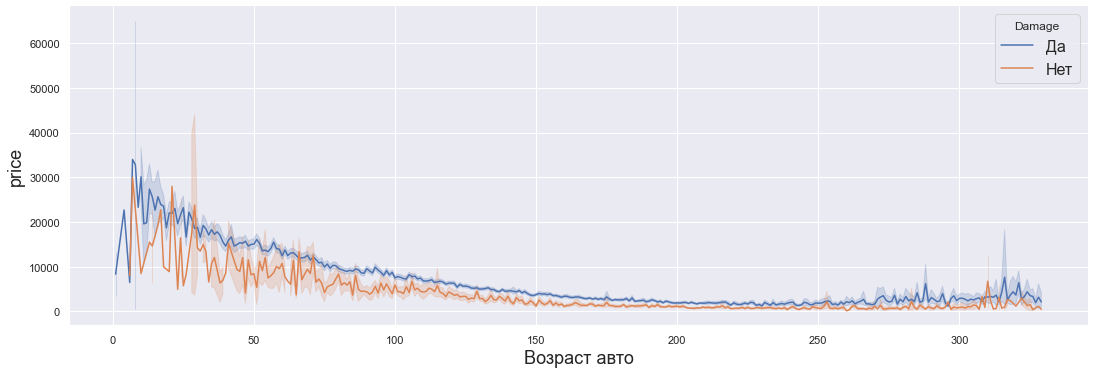

In [214]:
%matplotlib inline
#fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(18, 12))

# notRepairedDamage
sns.relplot(data = data_train, x = 'powerPS', y = 'price', hue = 'notRepairedDamage', height=5, aspect=3, kind = 'line', legend = False)#, ax = ax[0])
plt.ylabel('price', fontsize=18)
plt.xlabel('powerPS', fontsize=18)
plt.legend(['Да', 'Нет'], title='Damage', fontsize=16)

# kilometer
sns.relplot(data = data_train, x = 'kilometer', y = 'price', hue = 'notRepairedDamage', height=5, aspect=3, kind = 'line', legend = False)#, ax = ax[1])
plt.ylabel('price', fontsize=18)
plt.xlabel('kilometer', fontsize=18)
plt.legend(['Да', 'Нет'], title='Damage', fontsize=16)

# autoAgeMonths
sns.relplot(data = data_train, x = 'autoAgeMonths', y = 'price', hue = 'notRepairedDamage', height=5, aspect=3, kind = 'line', legend = False)#, ax = ax[2])
plt.ylabel('price', fontsize=18)
plt.xlabel('Возраст авто', fontsize=18)
plt.legend(['Да', 'Нет'], title='Damage', fontsize=16)

plt.show()

<div style="background: #f0f4e6; border: 2px solid #6b8e23;">
    <p style="margin: 15px; line-height: 1.5; text-align: left;">
        Итого в числовых значениях выбросы очищены<br>
        Зависимости стали более явными - чем больше мощность, тем больше цена, чем больше пробег и возраст (=износ), тем цена меньше

---

In [231]:
categorical = ['brand', 'fuelType', 'vehicleType']
numeric = ['powerPS', 'kilometer', 'autoAgeMonths']
other = ['gearbox', 'notRepairedDamage']

In [232]:
data_train['bias'] = 1
X_test['bias'] = 1
X_validate['bias'] = 1

other += ['bias']

In [ ]:
X_train = data_train[categorical + numeric + other]
Y_train = data_train['log_price']

X_test = X_test[categorical + numeric + other]
Y_test = Y_test['log_price']
X_validate = X_validate[categorical + numeric + other]
Y_validate = Y_validate['log_price']

In [234]:
X_train[numeric].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44083 entries, 91207 to 90241
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   powerPS        44083 non-null  int64
 1   kilometer      44083 non-null  int64
 2   autoAgeMonths  44083 non-null  int64
dtypes: int64(3)
memory usage: 1.3 MB


In [235]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler


column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numeric),
    ('other',  'passthrough', other)
])

In [236]:
X_train_sc = column_transformer.fit_transform(X_train)

In [237]:
X_test_sc = column_transformer.fit_transform(X_test)

In [238]:
X_validate_sc = column_transformer.fit_transform(X_validate)

## Задание 5. Сравнение методов градиентного спуска (2 балла)

В этом задании вам предстоит сравнить методы градиентного спуска на подготовленных вами данных из предыдущего задания.

### Задание 5.1. Подбор оптимальной длины шага (1 балл)

Подберите по валидационной выборке наилучшую длину шага $\lambda$ для каждого метода с точки зрения ошибки. Для этого сделайте перебор по логарифмической сетке. Для каждого метода посчитайте ошибку на обучающей и тестовой выборках, посчитайте качество по метрике $R^2$, сохраните количество итераций до сходимости.

Все параметры кроме `lambda_` стоит выставить равным значениям по умолчанию.

In [253]:
from sklearn.metrics import r2_score
alphas = np.logspace(-3, 0, 15)

descents = ['full', 'stochastic', 'momentum', 'adam']
dimension_ = X_train_sc.shape[1]

# Топ параметры с точки зрения ошибки
lambda_spaces = {
    'full': np.logspace(0., 0.3, 15),
    'stochastic': np.logspace(-0.4, -0.1, 15),
    'momentum': np.logspace(-0.4, 0, 15),
    'adam': np.logspace(0., 0.3,  15),
}

# Топ параметры для визуализации графиков
lambda_spaces = {
    'full': np.logspace(-0.9, -0.2, 15),
    'stochastic': np.logspace(-0.9, -0.2, 15),
    'momentum': np.logspace(-0.9, -0.2, 15),
    'adam': np.logspace(-0.9, -0.2, 15),
}

best_lambdas = {
    'full':   None,
    'stochastic': None,
    'momentum':   None,
    'adam':    None,
}


for descent_name_ in descents:
    best_loss = np.inf
    
    print(f'Descent type = {descent_name_}:')
    
    for i, lambda_ in enumerate(lambda_spaces[descent_name_]):
        descent_config = {
            'descent_name': descent_name_,
            'kwargs': {'dimension': dimension_, 'lambda_' : lambda_}
        }
        
        model = LinearRegression(descent_config=descent_config)
        model.fit(X_train_sc, np.array(Y_train))
        
        train_loss = model.calc_loss(X_train_sc, np.array(Y_train))
        validate_loss = model.calc_loss(X_validate_sc, np.array(Y_validate))
        r2_validate = r2_score(Y_validate, model.predict(X_validate_sc))
        r2_train = r2_score(Y_train, model.predict(X_train_sc))

        print(f'    lambda = {lambda_:6f}')
        print(f'    train loss = {train_loss:6f}, R^2 score = {r2_train:6f} {" " * 10} validation loss = {validate_loss:6f}, R^2 score = {r2_validate:6f}')

        if validate_loss < best_loss:
            best_loss = validate_loss
            best_lambdas[descent_name_] = lambda_
    print('*' * 100)

Descent type = full:
    lambda = 0.125893
    train loss = 0.631696, R^2 score = 0.441917            validation loss = 0.810091, R^2 score = 0.390797
    lambda = 0.141254
    train loss = 0.795026, R^2 score = 0.297621            validation loss = 0.937536, R^2 score = 0.294956
    lambda = 0.158489
    train loss = 0.736167, R^2 score = 0.349620            validation loss = 0.898229, R^2 score = 0.324515
    lambda = 0.177828
    train loss = 0.493417, R^2 score = 0.564082            validation loss = 0.658022, R^2 score = 0.505156
    lambda = 0.199526
    train loss = 0.584820, R^2 score = 0.483331            validation loss = 0.784626, R^2 score = 0.409948
    lambda = 0.223872
    train loss = 0.628892, R^2 score = 0.444394            validation loss = 0.785476, R^2 score = 0.409308
    lambda = 0.251189
    train loss = 0.525642, R^2 score = 0.535613            validation loss = 0.706336, R^2 score = 0.468822
    lambda = 0.281838
    train loss = 0.524660, R^2 score = 0.536480

In [254]:
best_loss

0.40058118672248194

In [257]:
# обучение на топ параметрах
loss_history = {}
iteration_max = {}

descents = ['full', 'stochastic', 'momentum', 'adam']
dimension_ = X_train_sc.shape[1]

for descent_name_ in descents:
    print(f'Descent type = {descent_name_}:')
    
    descent_config = {
        'descent_name': descent_name_,
        'kwargs': {'dimension': dimension_, 'lambda_' : best_lambdas[descent_name_]}
    }

    model = LinearRegression(descent_config=descent_config)
    model.fit(X_train_sc, np.array(Y_train))
    
    loss_history[descent_name_] = model.loss_history
    iteration_max[descent_name_] = len(model.loss_history)
    
    train_loss = model.calc_loss(X_train_sc, np.array(Y_train))
    validate_loss = model.calc_loss(X_validate_sc, np.array(Y_validate))
    r2_validate = r2_score(Y_validate, model.predict(X_validate_sc))
    r2_train = r2_score(Y_train, model.predict(X_train_sc))
    
    print(f'lambda= {best_lambdas[descent_name_]:6f}')
    print(f'    train loss = {train_loss:6f}, R^2 score= {r2_train:6f} {" " * 10} validation loss = {validate_loss:6f}, R^2 score = {r2_validate:6f}')
    print('*' * 100)

Descent type = full:
lambda= 0.630957
    train loss = 0.310430, R^2 score= 0.725745            validation loss = 0.490616, R^2 score = 0.631048
****************************************************************************************************
Descent type = stochastic:
lambda= 0.562341
    train loss = 0.613276, R^2 score= 0.458191            validation loss = 0.839126, R^2 score = 0.368962
****************************************************************************************************
Descent type = momentum:
lambda= 0.281838
    train loss = 0.215157, R^2 score= 0.809916            validation loss = 0.404360, R^2 score = 0.695914
****************************************************************************************************
Descent type = adam:
lambda= 0.501187
    train loss = 0.243760, R^2 score= 0.784646            validation loss = 0.418635, R^2 score = 0.685179
****************************************************************************************************


### Задание 5.2. Сравнение методов (1 балла) 

Постройте график зависимости ошибки на обучающей выборке от номера итерации (все методы на одном графике).

Посмотрите на получившиеся результаты (таблички с метриками и график). Сравните методы между собой.

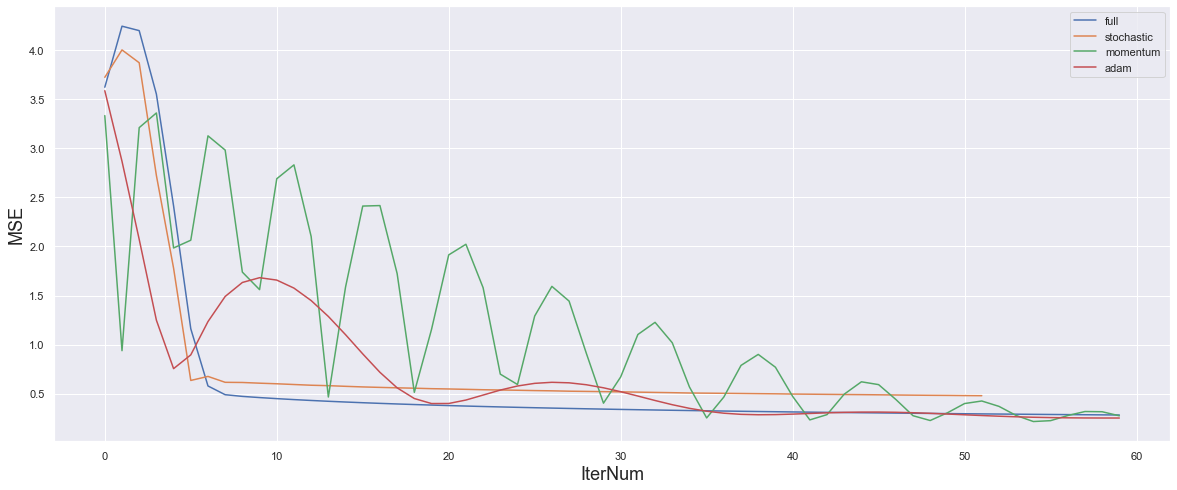

In [260]:
fig = plt.figure(figsize=(20, 8))

# Кол-во итераций = 60
for descent_name_ in descents:
    plt.plot(np.arange(iteration_max[descent_name_])[:60], np.log1p(loss_history[descent_name_][:60]), label=descent_name_)


plt.xlabel('IterNum', fontsize=18)
plt.ylabel('MSE', fontsize=18)
plt.legend()
plt.show()

<div style="background: #f0f4e6; border: 2px solid #6b8e23;">
    <p style="margin: 15px; line-height: 1.5; text-align: left;">
        <b>Full</b> <br>
        В стандартном градиентном спуске наблюдаетсясначала скачок ошибки, потом он быстрее всего сходится к минимуму. Возрастаний ошибки после первого скачка не наблюдается<br>
        Этому методу понадобилось меньшее количество итераций, так как у него точнее направленность градиента к минимуму и мы рассматриваем именно MSE, не имея локальных минимумов<br>
        <b>Stochastic</b><br>
        Стохастический градиентный спуск быстрее других свел ошибку к минимуму, при этом не останавливаясь на количестве заданных итераций<br>
        <b>Momentum</b><br>
        Количество итеграций для этого и Адам градиентного спуска потребовалось одинаковое. В данном<br>
        При этом в momentum ошибка скачет, но с каждой итерацией колебания все меньше<br>
        Главное преимущество метода - в том, что он может проскакивать локальные минимумы и добраться до глобального (как и у адам)<br>
        <b>Adam</b><br>
        В adam градиентном спуске ошибка раньше всего уменьшается, но далее возрастаю, колебаия также есть, как и в momentum, но амплитуда меньше

## Задание 6. Стохастический градиентный спуск и размер батча (1 балл)

В этом задании вам предстоит исследовать влияние размера батча на работу стохастического градиентного спуска. 

* Сделайте по несколько запусков (например, k = 10) стохастического градиентного спуска на обучающей выборке для каждого размера батча из перебираемого списка. Замерьте время в секундах и количество итераций до сходимости. Посчитайте среднее этих значений для каждого размера батча.
* Постройте график зависимости количества шагов до сходимости от размера батча.
* Постройте график зависимости времени до сходимости от размера батча.

Посмотрите на получившиеся результаты. Какие выводы можно сделать про подбор размера батча для стохастического градиентного спуска?

In [263]:
batch_sizes = np.arange(5, 500, 10)

from time import time

dimension_ = X_train_sc.shape[1]
times_res = []
iterations_res = []

for batch_size in batch_sizes:
    times = []
    iterations = []   
    descent_config = {
        'descent_name': 'stochastic',
        'kwargs': {
            'dimension': dimension_,
            'lambda_' : best_lambdas['stochastic'],
            'batch_size' : batch_size
        }
    }
    for k in range(10):
        model = LinearRegression(descent_config=descent_config)
        start = time()
        model.fit(X_train_sc, np.array(Y_train))
        times.append(time() - start)
        iterations.append(len(model.loss_history))

    times_res.append(np.array(times).mean())
    iterations_res.append(np.array(iterations).mean())

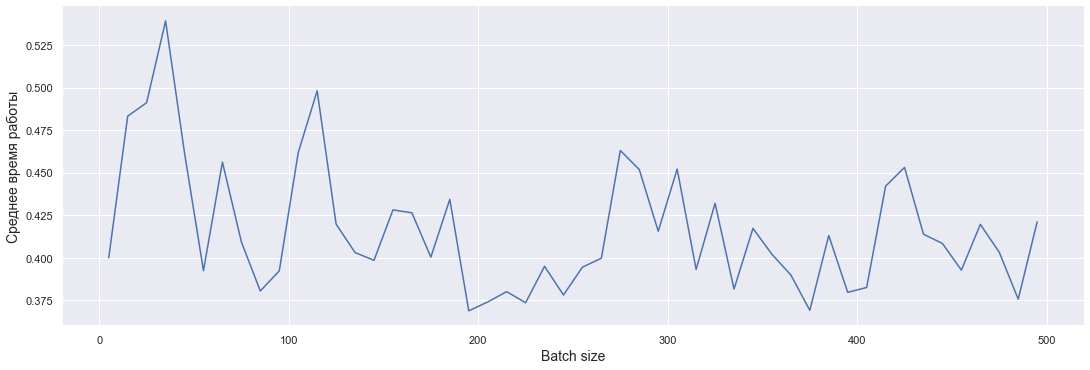

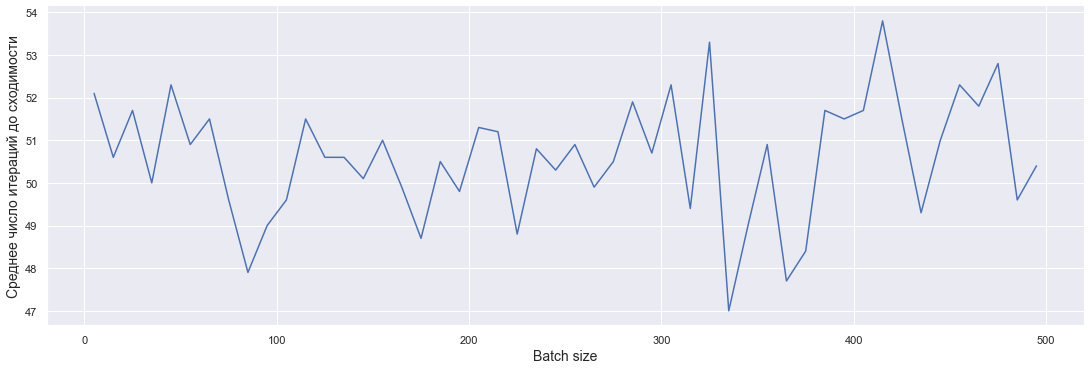

In [281]:
%matplotlib inline

# Зависимость средного времени работы SGD от размера батча
sns.relplot(x = batch_sizes, y = times_res, height=5, aspect=3, kind = 'line')
plt.ylabel('Среднее время работы', fontsize=14)
plt.xlabel('Batch size', fontsize=14)

# Зависимость средного числа итераций SGD до сходимости от размера батча
sns.relplot(x = batch_sizes, y = iterations_res, height=5, aspect=3, kind = 'line')
plt.ylabel('Среднее число итераций до сходимости', fontsize=14)
plt.xlabel('Batch size', fontsize=14)

plt.show()

<div style="background: #f0f4e6; border: 2px solid #6b8e23;">
    <p style="margin: 15px; line-height: 1.5; text-align: left;">
        Относительно времени работы - увеличесние батча уменьшает время работы алгоритма, но колебания также остаются.<br>
        Относительно количества итераций в зависимости от размера батча: нельзя сказать строго положительная или строго отрицательная зависимость, приэтом колебания после батча 300 увеличились, скорее всего из-за усложнения вычисления градиента<br>
        Поэтому выбор размера батча важен при использовании метода стохастического градиентного спуска

## Задание 7. Регуляризация (1 балл)

В этом задании вам предстоит исследовать влияние регуляризации на работу различных методов градиентного спуска. Напомним, регуляризация - это добавка к функции потерь, которая штрафует за норму весов. Мы будем использовать l2 регуляризацию, таким образом функция потерь приобретает следующий вид:

$$
    Q(w) = \dfrac{1}{\ell} \sum\limits_{i=1}^{\ell} (a_w(x_i) - y_i)^2 + \dfrac{\mu}{2} \| w \|^2
$$

Допишите класс **BaseDescentReg** в файле `descents.py`.

Протестируйте ваше решение в контесте.

Вставьте ссылку на успешную посылку:

* **BaseDescentReg**: [ссылка 6](https://contest.yandex.ru/contest/41257/run-report/73989014/)

Найдите лучшие параметры обучения с регуляризацией аналогично 5 заданию. Будем подбирать длину шага $\lambda$ (`lambda_`) и коэффициент регуляризации $\mu$ (`mu`).

Сравните для каждого метода результаты с регуляризацией и без регуляризации (нужно опять сохранить ошибку и качество по метрике $R^2$ на обучающей и тестовой выборках и количество итераций до сходимости).

Постройте для каждого метода график со значениями функции потерь MSE с регуляризацией и без регуляризации (всего должно получиться 4 графика).

Посмотрите на получившиеся результаты. Какие можно сделать выводы, как регуляризация влияет на сходимость? Как изменилось качество на обучающей выборке? На тестовой? Чем вы можете объяснить это?

In [282]:
from sklearn.metrics import mean_squared_error, r2_score
import math

descents = ['full', 'stochastic', 'momentum', 'adam']
dimension_ = X_train_sc.shape[1]

# Топ параметры с точки зрения ошибки
lambda_spaces = {
    'full': np.logspace(0., 0.3, 15),
    'stochastic': np.logspace(-0.4, -0.1, 15),
    'momentum': np.logspace(-0.4, 0, 15),
    'adam': np.logspace(0., 0.3,  15),
}

# Топ параметры для визуализации графиков
lambda_spaces = {
    'full': np.logspace(-0.9, -0.2, 15),
    'stochastic': np.logspace(-0.9, -0.2, 15),
    'momentum': np.logspace(-0.9, -0.2, 15),
    'adam': np.logspace(-0.9, -0.2, 15),
}

mu_spaces = np.logspace(-0.7, -0.3, 5)

best_lambdas = {
    'full':   None,
    'stochastic': None,
    'momentum':   None,
    'adam':    None,
}

best_mu = {
    'full':   None,
    'stochastic': None,
    'momentum':   None,
    'adam':    None,
}


for descent_name_ in descents:
    best_loss = np.inf
    print(f'{"_" * 35} Descent type = {descent_name_} {"_" * 35}')
    
    for mu_ in mu_spaces:
        is_print = False
        for i, lambda_ in enumerate(lambda_spaces[descent_name_]):
            descent_config = {
                'descent_name': descent_name_, 'regularized': True,
                'kwargs': {'dimension': dimension_, 'lambda_' : lambda_, 'mu': mu_}
            }

            regression = LinearRegression(descent_config=descent_config)
            regression.fit(X_train_sc, np.array(Y_train))

            train_loss = regression.calc_loss(X_train_sc, np.array(Y_train))
            validate_loss = regression.calc_loss(X_validate_sc, np.array(Y_validate))
            r2_validate = r2_score(Y_validate, regression.predict(X_validate_sc))
            r2_train = r2_score(Y_train, regression.predict(X_train_sc))

            if validate_loss < best_loss:
                best_loss = validate_loss
                best_lambdas[descent_name_] = lambda_
                best_mu[descent_name_] = mu_
                print(f'    lambda = {lambda_:6f} {" " * 10} mu =  {mu_:6f}')
                print(f'    train loss = {train_loss:6f}, R^2 score= {r2_train:6f} {" " * 10} validation loss = {validate_loss:6f}, R^2 score= {r2_validate:6f}\n')
                is_print = True
        
        if is_print:
            print('*' * 100)

_________________________ Descent type = full _________________________
    lambda = 0.125893            mu =  0.199526
    train loss = 0.589266, R^2 score= 0.479402            validation loss = 0.790742, R^2 score= 0.405348

    lambda = 0.141254            mu =  0.199526
    train loss = 0.534008, R^2 score= 0.528221            validation loss = 0.759365, R^2 score= 0.428944

    lambda = 0.158489            mu =  0.199526
    train loss = 0.506403, R^2 score= 0.552610            validation loss = 0.709011, R^2 score= 0.466811

    lambda = 0.177828            mu =  0.199526
    train loss = 0.443260, R^2 score= 0.608394            validation loss = 0.654192, R^2 score= 0.508036

    lambda = 0.199526            mu =  0.199526
    train loss = 0.424875, R^2 score= 0.624637            validation loss = 0.636879, R^2 score= 0.521056

    lambda = 0.223872            mu =  0.199526
    train loss = 0.391930, R^2 score= 0.653742            validation loss = 0.597465, R^2 score= 0.550696

    lambda = 0.630957            mu =  0.199526
    train loss = 0.247374, R^2 score= 0.781453            validation loss = 0.452089, R^2 score= 0.660021

****************************************************************************************************


In [284]:
# обучение на топ параметрах

loss_history_reg = {}
iteration_max_reg = {}

descents = ['full', 'stochastic', 'momentum', 'adam']
dimension_ = X_train_sc.shape[1]

for descent_name_ in descents:
    print(f'Descent type = {descent_name_}:')
    
    descent_config = {
        'descent_name': descent_name_, 'regularized' : True,
        'kwargs': {'dimension': dimension_, 'lambda_' : best_lambdas[descent_name_], 'mu': best_mu[descent_name_]}
    }

    model = LinearRegression(descent_config=descent_config)
    model.fit(X_train_sc, np.array(Y_train))
    
    loss_history_reg[descent_name_] = model.loss_history
    iteration_max_reg[descent_name_] = len(model.loss_history)
    
    train_loss = model.calc_loss(X_train_sc, np.array(Y_train))
    validate_loss = model.calc_loss(X_validate_sc, np.array(Y_validate))
    r2_validate = r2_score(Y_validate, regression.predict(X_validate_sc))
    r2_train = r2_score(Y_train, regression.predict(X_train_sc))

    print(f'lambda = {lambda_:6f} {" " * 10} mu =  {mu_:6f}')
    print(f'train loss = {train_loss:6f}, R^2 score= {r2_train:6f} {" " * 10} validation loss = {validate_loss:6f}, R^2 score= {r2_validate:6f}\n')
    print('*' * 100)

Descent type = full:
lambda = 0.630957            mu =  0.501187
train loss = 0.240036, R^2 score= 0.761138            validation loss = 0.444464, R^2 score= 0.636152

****************************************************************************************************
Descent type = stochastic:
lambda = 0.630957            mu =  0.501187
train loss = 0.279047, R^2 score= 0.761138            validation loss = 0.516156, R^2 score= 0.636152

****************************************************************************************************
Descent type = momentum:
lambda = 0.630957            mu =  0.501187
train loss = 0.237708, R^2 score= 0.761138            validation loss = 0.418647, R^2 score= 0.636152

****************************************************************************************************
Descent type = adam:
lambda = 0.630957            mu =  0.501187
train loss = 0.240127, R^2 score= 0.761138            validation loss = 0.444156, R^2 score= 0.636152

***************

In [294]:
# визуализация

def draw(descent_name, max_iter=50):
    plt.plot(np.arange(iteration_max[descent_name])[:max_iter], loss_history[descent_name][:max_iter], label=f'{descent_name}')
    plt.plot(np.arange(iteration_max_reg[descent_name])[:max_iter], loss_history_reg[descent_name][:max_iter], label=f'{descent_name} reg')

    plt.title('Зависимость ошибки на train от номера итерации',  fontsize=18)
    plt.xlabel('Iter',  fontsize=14)
    plt.ylabel('MSE',  fontsize=14)
    plt.legend(loc="upper right")

    plt.show()

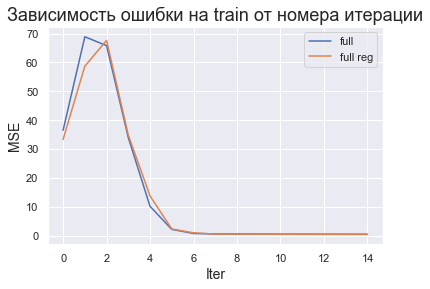

In [295]:
draw('full', 15)

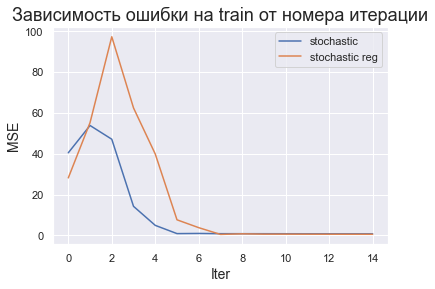

In [296]:
draw('stochastic', 15)

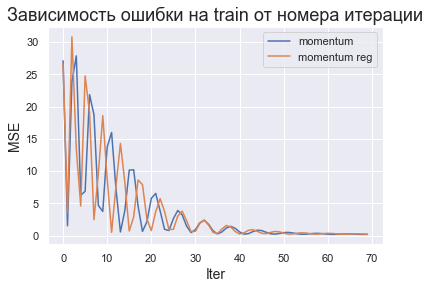

In [297]:
draw('momentum', 70)

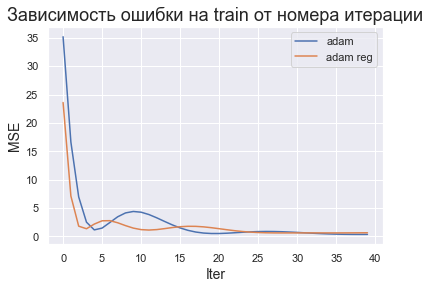

In [298]:
draw('adam', 40)

<div style="background: #f0f4e6; border: 2px solid #6b8e23;">
    <p style="margin: 15px; line-height: 1.5; text-align: left;">
        Заметно, что регуляризация дает аналигичный результат как на обучающей выборке, так и на валидационной. Сильное отличие видно в стохастическом методе - регуляризация повлияла на результат увеличением ошибки. Это говорит о том, что модель без регуляризации не переобучилась, поэтому регуляризация не сильно повлияла на результат<br>

## Задание 8. Альтернативная функция потерь (1 балл)

В этом задании вам предстоит использовать другую функцию потерь для нашей задачи регрессии. В качестве функции потерь мы выбрали **Log-Cosh**:

$$
    L(y, a)
    =
    \log\left(\cosh(a - y)\right).
$$

Самостоятельно продифференцируйте данную функцию потерь чтобы найти её градиент:

`### ваше решение тут ###`

Программно реализуйте градиентный спуск с данной функцией потерь в файле `descents.py`, обучите все четыре метода (без регуляризации) аналогично 5 заданию, сравните их качество с четырьмя методами из 5 задания.

Пример того, как можно запрограммировать использование нескольких функций потерь внутри одного класса градиентного спуска:


```python
from enum import auto
from enum import Enum

import numpy as np

class LossFunction(Enum):
    MSE = auto()
    MAE = auto()
    LogCosh = auto()
    Huber = auto()

...
class BaseDescent:
    def __init__(self, loss_function: LossFunction = LossFunction.MSE):
        self.loss_function: LossFunction = loss_function

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        if self.loss_function is LossFunction.MSE:
            return ...
        elif self.loss_function is LossFunction.LogCosh:
            return ...
...

```

In [ ]:
# YOUR CODE:

### Кулинарно-социализационный бонус. (0.5 балла).

Как мы знаем, осень прекрасная пора, время пробовать новое и делиться теплом с друзьями и близкими. Выберите рецепт, который соответствует вашему настроению, приготовьте выбранное блюдо и угостите хотя бы одного человека им. Кратко опишите ваши впечатления, прикрепите рецепт и фотографии блюда и довольного гостя.

<div style="background: #fffff2; border: 3px solid #ffb266;">
    <p style="margin: 15px; line-height: 1.5; text-align: left;">
        Фото гостя не нашлось (быстро все съели😜), но рецептик потрясающий: курица с овощами по лимонным соком с оливковым маслом (можно еще добавить тимьян или растение тархун)

<img>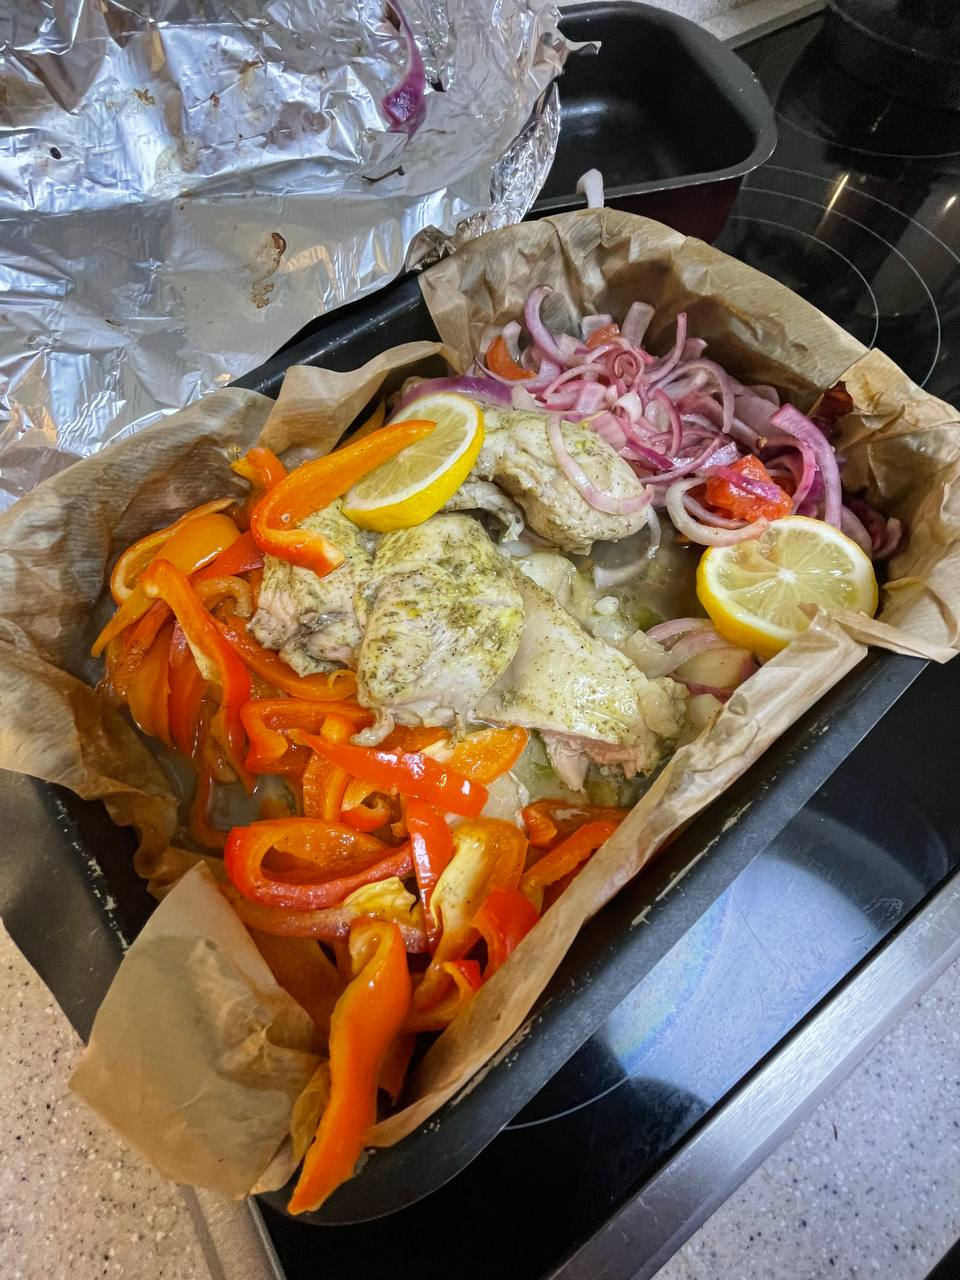</img>

### Бонус 1. Другие методы градиентного спуска (1 балл).

По желанию выберите метод градиентного спуска из следующего списка и самостоятельно реализуйте его в файле `descents.py`. Обучите линейную регрессию с помощью этого метода, сравните с методами из основной части домашнего задания.

`AdaMax` (вариация Adam основанная на $l_{\infty}$), `Nadam` (вариация Adam совмещенная с методом импульса Нестерова), `AMSGrad` (ещё одна вариация Adam).

In [ ]:
# YOUR CODE:

### Бонус 2. Другие функции потерь (1 балл).

Аналогично 8 заданию реализуйте две функции потерь - **MAE** и **Huber**.

Самостоятельно продифференцируйте данные функции потерь, чтобы найти их градиенты:

`### ваше решение тут ###`

Программно реализуйте градиентный спуск с данными функциями потерь в файле `descents.py`, обучите все четыре метода (без регуляризации) аналогично 5 заданию, сравните их качество с четырьмя методами из 5 задания.

Сравните между собой *для каждого метода отдельно* качество для разных функций потерь. Какая оказалась лучше? Как вы думаете почему?

In [ ]:
# YOUR CODE: